# Forecasting Malaysia's Total Export Value with Machine Learning Regression Models

## Import libraries and packages

In [1]:
import requests
import pandas as pd
import json
import io
import os
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import logging
from airflow.exceptions import AirflowFailException
from bs4 import BeautifulSoup
from bs4.element import Tag
from dateutil.relativedelta import relativedelta
from fredapi import Fred
from imfpy import searches, retrievals
from typing import Optional
from requests.adapters import HTTPAdapter
from urllib3.util import Retry
from dotenv import load_dotenv
from google.cloud import storage
from google.cloud import bigquery
from google.cloud.exceptions import NotFound
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn import metrics #to evaluate the accuracy of our ml model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from pmdarima.arima import auto_arima

## ETL Process

### Malaysia's Total Export and Import Value from METS OnlineFred

#### Functions for Google Cloud

In [2]:
# Define a function for uploading data to Google Storage Bucket    
def upload_to_bucket(data_list,
                     client,
                     bucket_name,
                     blob_name,
                     file_format,
                     ):
    
    if data_list is None:
        logging.warning("Please ensure data_list has a value.")
        return
    
    my_bucket = storage_client.bucket(bucket_name)
    # Check if the specified bucet_name exists or not
    if not my_bucket.exists(): # If the bucket does not exist
        try:
            logging.info(f'Bucket - {bucket_name} is not found.')
            logging.info(f"Creating {bucket_name} in progress ...")
            my_bucket.create() # Create the bucket with the specified name
            logging.info(f"SUCCESS: {bucket_name} has been created.")
            
        except Exception as e:
            logging.info(f"Error creating bucket: {e}")
   
    try:
        # To create a list to store the gsutil uri 
        gcs_uri_list = []
        for i in range(len(data_list)):
            # timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S ')
            # blob_name = item.name + " " + timestamp
            blob = my_bucket.blob(blob_name[i])
            logging.info(f"Uploading file to GCS in progress ...")
            if file_format == "csv":
                blob.upload_from_string(data_list[i].to_csv(index=False), content_type='text/csv')
            elif file_format == "txt" or file_format == "html":
                blob.upload_from_string(data_list[i])
            else:
                logging.error(f"The file format - {file_format} is not supported.")
                return 
            logging.info(f'SUCCESS: {blob} has successfully uploaded to {my_bucket}.')
            gcs_uri = f"gs://{bucket_name}/{blob_name[i]}"
            gcs_uri_list.append(gcs_uri) 
        return gcs_uri_list

    except Exception as e:
        logging.error(f"Error: {e}")

def read_file_from_gcs(gcs_uri_list, client):
    data_list = []
    for gcs_uri in gcs_uri_list:
        bucket_name, blob_name = gcs_uri.split("//")[1].split("/",1)
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(blob_name)
        logging.info(f"Reading file - {gcs_uri} from GCS in progress ...")
        result = blob.download_as_string()
        logging.info(f"SUCCESS: The file from {gcs_uri} has been successfully read.")
        data_list.append(result)
    return data_list

# Define a function to load data from google bucket to google bigquery
def upload_to_bigquery(client, dataset_name, table_name, job_config, gcs_uri_list):
    try:
        for i in range(len(table_name)): 
            # Look up for dataset
            dataset_ref = client.dataset(dataset_name)
            try:
                targeted_dataset = client.get_dataset(dataset_ref)
                logging.info(f'Dataset {targeted_dataset.dataset_id} already exists.')
            # Create new dataset if not found
            except NotFound:
                logging.info(f"Dataset {dataset_ref} is not found")
                logging.info(f"Creating dataset - {dataset_ref} in progress ...")
                targeted_dataset = client.create_dataset(dataset_ref)
                logging.info(f'Dataset {targeted_dataset.dataset_id} created.')

            # Look up for table
            table_ref = dataset_ref.table(table_name[i])
            try:
                targeted_table = client.get_table(table_ref)
                logging.info(f'Table {targeted_table.table_id} already exists.')
            # Create new table if not found
            except NotFound:
                logging.info(f"Dataset {table_ref} is not found")
                logging.info(f"Creating table - {table_ref} in progress ...")
                targeted_table = client.create_table(table_ref)
                logging.info(f'Table {targeted_table.table_id} created.')

            # Upload the data to bigquery table using gsutil URI
            load_job = client.load_table_from_uri(gcs_uri_list[i],
                                                  targeted_table, 
                                                  job_config=job_config)

            logging.info(load_job.result())
            logging.info(f"SUCCESS: The data has been loaded to Google BigQuery.")
        
    except Exception as e:
        logging.error(f"Error: {e}")
        
def create_blob_list(storage_client, 
                     bucket_name, 
                     df_list):
    if df_list is None:
        logging.warning("Please ensure df_list has a value.")
        exit()
    
    my_bucket = storage_client.bucket(bucket_name)
    # Check if the specified bucet_name exists or not
    if not my_bucket.exists(): # If the bucket does not exist
        try:
            logging.info(f'Bucket - {bucket_name} is not found.')
            logging.info(f"Creating {bucket_name} in progress ...")
            my_bucket.create() # Create the bucket with the specified name
            logging.info(f"SUCCESS: {bucket_name} has been created.")
            
        except Exception as e:
            logging.error(f"Error creating bucket: {e}")
                  
    else:
        logging.info(f"Bucket - {bucket_name} is found.")
    
    try:
        # To create a list to store all the blobs uploaded to the bucket
        blob_list =[]
        for item in df_list:
            blob_name = item.name
            blob = my_bucket.blob(blob_name)
            logging.info(f"Uploading data to Google Storage Bucket in progress ...")
            blob.upload_from_string(item.to_csv(index=False), 'text/csv')
            logging.info(f"SUCCESS: {blob} has been uploaded to {my_bucket}.")
            blob_list.append(blob_name)
        return blob_list
            
    except Exception as e:
        logging.error(f"Error: {e}")

#### Functions for METS ETL

In [3]:
# Define a function for extracting raw data from METS Online
def mets_extract_html(url,
                      payload: Optional[dict] = None,
                      headers: Optional[dict] = None
                      ):
    
    # Specify the maximum number of retry
    MAX_RETRIES = 5
    
    # Define the retry strategy
    retry_strategy = Retry(total = MAX_RETRIES,
                           backoff_factor = 2,
                           status_forcelist = [429, 500, 502, 503, 504],
                           allowed_methods = ["GET", "POST"])
    
    # Create an HTTP adapter with the retry strategy and mount it to session
    adapter = HTTPAdapter(max_retries=retry_strategy)
    
    # Create a new session object
    session = requests.Session()
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    
    logging.info("Extracting raw data in progress ...")
    # Make a request using the created session object
    raw_html = session.post(url,
                            data = payload,
                            headers = headers,
                            verify = False)
    data_list = []
    if raw_html.status_code == 200:
        logging.info('SUCCESS: Raw Data has been extracted.')
        result = raw_html.content
        # Parse the HTML
        # result = BeautifulSoup(raw_html.text, 'html.parser')
        data_list.append(result)
        return data_list

    else:
        logging.error(f'Error: Fail to extract the raw data. ErrorCode: {raw_html.status_code}.')

# Define a function for basic preprocessing on the extracted raw html text.
def mets_preprocess(gcs_uri_list,
                    client):
    data_list = read_file_from_gcs(gcs_uri_list = gcs_uri_list, client=storage_client)
    for item in data_list:
        try:
            html_content = BeautifulSoup(item, 'html.parser')
            logging.info("Extracting data from from html contents in progress ...")
            # Look up for the table
            result = html_content.find('table', class_='table-bordered')

            # Extract table rows
            rows = result.find_all('tr')

            individual_data = []
            for row in rows:
                data = row.find_all(['th', 'td'])
                if data:
                    data = [item.get_text(strip=True) for item in data]
                    if 'GRAND TOTAL' not in data:
                        individual_data.append(data)

            logging.info('Converting raw extracted data to dataframe in progress ...')
            # Select a subset of columns from the first row as column names
            df = pd.DataFrame(individual_data[1:], columns=individual_data[0])
            # To remove the yearly data column due to redundancy 
            data_month_filter = [col for col in df.columns if '-' not in col or not any(char.isdigit() for char in col)]
            df_list = []
            df_monthly = df.loc[:, data_month_filter]
            df_list.append(df_monthly)
            logging.info(f'SUCCESS: Dataframe has been created')
            return df_list
        except Exception as e:
            logging.error(f"Error: {e}")

def mets_transformation(gcs_uri_list,
                        client,
                        new_column_name,):
    
    data_list = read_file_from_gcs(gcs_uri_list = gcs_uri_list, client=storage_client)

    try:
        transformed_df_list = []
        replacements = {' ': '_',
                        '&': '',
                        ',': '',
                        '.': '',}
        try:
            for item in data_list:
                item = pd.read_csv(io.BytesIO(item))
                df = item.transpose().reset_index()
                column_name = list(df.iloc[2,:])
                edited_column_name = []

                # To replace the selected symbols and empty spaces
                for column in column_name:
                    for old, new in replacements.items():
                        column = column.replace(old, new)
                    edited_column_name.append(column)

                df = df.iloc[3:]
                df.columns = edited_column_name
                df = df.rename(columns={'PRODUCT_DESCRIPTION': 'date'})

                # To convert the 'date' column to datetime format, whereas the others are converted to numeric.
                for column in df.columns:
                    if column == 'date':
                        df[column] = pd.to_datetime(df[column])
                    else:
                        df[column] = pd.to_numeric(df[column].str.replace(',', ''))

                # Create a new column which sum all the values from other columns in the same row
                df[new_column_name] = df.iloc[:,1:].sum(axis=1)

                transformed_df_list.append(df)
                logging.info(f"SUCCESS: Transformed Dataframe has been created.")
                return transformed_df_list
            
        except Exception as e:
            logging.error(f"Error: {e}")
            return None
        
    except Exception as e:
        logging.error(f"Error: {e}")
        return None

#### Input parameters

In [4]:
load_dotenv()

# Retrieve the csrf_token and Cookie values
csrf_token = os.getenv("csrf_token")
Cookie = os.getenv("cookie")

# URL of targeted site
url = "https://metsonline.dosm.gov.my/tradev2/product-coderesult"

# headers of targeted site
headers = {
    "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
    "Cookie": "PHPSESSID=938e8fjm1hj9bb07oq3u4fisi4; _csrf=615b79fbeb5a5e5147fee3ac2245a8abb4f3d106b51ba953154dfe4b8036f358a%3A2%3A%7Bi%3A0%3Bs%3A5%3A%22_csrf%22%3Bi%3A1%3Bs%3A32%3A%22V4KGkyVFWmBgtSAZPHpnC8MV4N1-eYuB%22%3B%7D; cookiesession1=678B288423AE9070F6271BFC1DD8DA77"
}

# payload of targeted site
payload_exports = {
    "_csrf": "Q3RsVE1CS1QVQCcTJjsdEhQZLjM5EQoOEzwcOg56BgJ3Ol15KBs.Fg==",
    "Tradev2[typeofsearch]": "classification",
    "Tradev2[typedigit]": 7,
    "Tradev2[rangecode1]": 0,
    "Tradev2[rangecode2]": 9,
    # 'Tradev2[code_idcode]': ,
    # 'Tradev2[code_idcodedigit9]': ,
    # 'Tradev2[tradeflow]': ,
    "Tradev2[tradeflow][]": "exports",
    # 'Tradev2[timeframe]': ,
    "Tradev2[timeframe]": "month",
    # 'Tradev2[rangeyear]': ,
    # 'Tradev2[rangeyear2]': ,
    # 'Tradev2[rangeyearone]': ,
    # 'Tradev2[rangemonthone]': ,
    "Tradev2[mothdata]": 2000,
    "Tradev2[mothdata2]": 2023,
    # 'Tradev2[classification_serch]': ,
    # 'Tradev2[country2]': ,
    "Tradev2[geogroup]": 1,
    "Tradev2[geogroup]": 29,
    "Tradev2[codeshowby]": "code",
}

# payload of targeted site
payload_imports = {
    "_csrf": "Q3RsVE1CS1QVQCcTJjsdEhQZLjM5EQoOEzwcOg56BgJ3Ol15KBs.Fg==",
    "Tradev2[typeofsearch]": "classification",
    "Tradev2[typedigit]": 7,
    "Tradev2[rangecode1]": 0,
    "Tradev2[rangecode2]": 9,
    # 'Tradev2[code_idcode]': ,
    # 'Tradev2[code_idcodedigit9]': ,
    # 'Tradev2[tradeflow]': ,
    "Tradev2[tradeflow][]": "imports",
    # 'Tradev2[timeframe]': ,
    "Tradev2[timeframe]": "month",
    # 'Tradev2[rangeyear]': ,
    # 'Tradev2[rangeyear2]': ,
    # 'Tradev2[rangeyearone]': ,
    # 'Tradev2[rangemonthone]': ,
    "Tradev2[mothdata]": 2000,
    "Tradev2[mothdata2]": 2023,
    # 'Tradev2[classification_serch]': ,
    # 'Tradev2[country2]': ,
    "Tradev2[geogroup]": 1,
    "Tradev2[geogroup]": 29,
    "Tradev2[codeshowby]": "code",
}
# Google Cloud Parts
# Convert the credentials to .json file for the usage of GOOGLE_APPLICATION_CREDENTIALS
CREDENTIALS = json.loads(os.getenv('CREDENTIALS'))

# Check if there's an existing credentials file
with open('credentials.json', 'w') as cred_file:
    json.dump(CREDENTIALS, cred_file)
    
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='credentials.json'

storage_client = storage.Client()
bq_client = bigquery.Client()
job_config = bigquery.LoadJobConfig(source_format=bigquery.SourceFormat.CSV,
                                    write_disposition='WRITE_TRUNCATE',
                                    skip_leading_rows=1,
                                    autodetect=True,)

#### Test Run for Exports

In [5]:
data_list = mets_extract_html(url=url,
                              payload=payload_exports,
                              headers=headers,)

[2024-02-11T14:30:46.727+0800] {2878466093.py:24} INFO - Extracting raw data in progress ...


C:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1045 InsecureRequestWarning: Unverified HTTPS request is being made to host 'metsonline.dosm.gov.my'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings

[2024-02-11T14:31:35.272+0800] {2878466093.py:32} INFO - SUCCESS: Raw Data has been extracted.


In [6]:
gcs_uri_list=upload_to_bucket(data_list=data_list,
                              client=storage_client,
                              bucket_name="wqd7002_test_area",
                              blob_name=["mets_export_request.html"],
                              file_format="html",)

[2024-02-11T14:34:24.232+0800] {1572077403.py:17} INFO - Bucket - wqd7002_test_area is not found.
[2024-02-11T14:34:24.232+0800] {1572077403.py:18} INFO - Creating wqd7002_test_area in progress ...
[2024-02-11T14:34:25.223+0800] {1572077403.py:20} INFO - SUCCESS: wqd7002_test_area has been created.
[2024-02-11T14:34:25.224+0800] {1572077403.py:32} INFO - Uploading file to GCS in progress ...
[2024-02-11T14:34:28.610+0800] {1572077403.py:40} INFO - SUCCESS: <Blob: wqd7002_test_area, mets_export_request.html, 1707633268366647> has successfully uploaded to <Bucket: wqd7002_test_area>.


In [7]:
df_list = mets_preprocess(gcs_uri_list=gcs_uri_list,client=storage_client)

[2024-02-11T14:34:29.295+0800] {1572077403.py:54} INFO - Reading file - gs://wqd7002_test_area/mets_export_request.html from GCS in progress ...
[2024-02-11T14:34:32.555+0800] {1572077403.py:56} INFO - SUCCESS: The file from gs://wqd7002_test_area/mets_export_request.html has been successfully read.
[2024-02-11T14:34:32.911+0800] {2878466093.py:49} INFO - Extracting data from from html contents in progress ...
[2024-02-11T14:34:32.970+0800] {2878466093.py:64} INFO - Converting raw extracted data to dataframe in progress ...
[2024-02-11T14:34:32.977+0800] {2878466093.py:72} INFO - SUCCESS: Dataframe has been created


In [8]:
gcs_uri_list=upload_to_bucket(data_list=df_list,
                              client=storage_client,
                              bucket_name="wqd7002_test_area",
                              blob_name=["mets_raw_exports_data.csv"],
                              file_format="csv",)

[2024-02-11T14:34:33.707+0800] {1572077403.py:32} INFO - Uploading file to GCS in progress ...
[2024-02-11T14:34:34.838+0800] {1572077403.py:40} INFO - SUCCESS: <Blob: wqd7002_test_area, mets_raw_exports_data.csv, 1707633274579062> has successfully uploaded to <Bucket: wqd7002_test_area>.


In [9]:
transformed_df_list = mets_transformation(gcs_uri_list=gcs_uri_list,
                                          client=storage_client,
                                          new_column_name="my_total_export",)

[2024-02-11T14:34:35.520+0800] {1572077403.py:54} INFO - Reading file - gs://wqd7002_test_area/mets_raw_exports_data.csv from GCS in progress ...
[2024-02-11T14:34:38.773+0800] {1572077403.py:56} INFO - SUCCESS: The file from gs://wqd7002_test_area/mets_raw_exports_data.csv has been successfully read.
[2024-02-11T14:34:38.799+0800] {2878466093.py:117} INFO - SUCCESS: Transformed Dataframe has been created.


In [10]:
gcs_uri_list=upload_to_bucket(data_list=transformed_df_list,
                              client=storage_client,
                              bucket_name="wqd7002_test_area",
                              blob_name=["mets_transformed_exports_data.csv"],
                              file_format="csv",)

[2024-02-11T14:34:39.473+0800] {1572077403.py:32} INFO - Uploading file to GCS in progress ...
[2024-02-11T14:34:40.297+0800] {1572077403.py:40} INFO - SUCCESS: <Blob: wqd7002_test_area, mets_transformed_exports_data.csv, 1707633280052545> has successfully uploaded to <Bucket: wqd7002_test_area>.


In [11]:
upload_to_bigquery(client=bq_client,
                   dataset_name="wqd7002_test_area",
                   table_name=["malaysia_exports_data"],
                   job_config=job_config,
                   gcs_uri_list=gcs_uri_list)

[2024-02-11T14:36:26.224+0800] {1572077403.py:71} INFO - Dataset personal-project-401309.wqd7002_test_area is not found
[2024-02-11T14:36:26.225+0800] {1572077403.py:72} INFO - Creating dataset - personal-project-401309.wqd7002_test_area in progress ...
[2024-02-11T14:36:26.884+0800] {1572077403.py:74} INFO - Dataset wqd7002_test_area created.
[2024-02-11T14:36:27.197+0800] {1572077403.py:83} INFO - Dataset personal-project-401309.wqd7002_test_area.malaysia_exports_data is not found
[2024-02-11T14:36:27.197+0800] {1572077403.py:84} INFO - Creating table - personal-project-401309.wqd7002_test_area.malaysia_exports_data in progress ...
[2024-02-11T14:36:27.624+0800] {1572077403.py:86} INFO - Table malaysia_exports_data created.
[2024-02-11T14:36:31.191+0800] {1572077403.py:93} INFO - LoadJob<project=personal-project-401309, location=US, id=7c874405-9c40-433b-a7a7-f9771bfb896f>
[2024-02-11T14:36:31.192+0800] {1572077403.py:94} INFO - SUCCESS: The data has been loaded to Google BigQuery.


#### Test run for Imports

In [12]:
data_list = mets_extract_html(url=url,
                              payload=payload_imports,
                              headers=headers,)

[2024-02-11T14:36:31.196+0800] {2878466093.py:24} INFO - Extracting raw data in progress ...


C:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1045 InsecureRequestWarning: Unverified HTTPS request is being made to host 'metsonline.dosm.gov.my'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings

[2024-02-11T14:37:26.228+0800] {2878466093.py:32} INFO - SUCCESS: Raw Data has been extracted.


In [13]:
gcs_uri_list=upload_to_bucket(data_list=data_list,
                              client=storage_client,
                              bucket_name="wqd7002_test_area",
                              blob_name=["mets_import_request.html"],
                              file_format="html",)

[2024-02-11T14:37:26.966+0800] {1572077403.py:32} INFO - Uploading file to GCS in progress ...
[2024-02-11T14:37:27.845+0800] {1572077403.py:40} INFO - SUCCESS: <Blob: wqd7002_test_area, mets_import_request.html, 1707633447604496> has successfully uploaded to <Bucket: wqd7002_test_area>.


In [14]:
df_list = mets_preprocess(gcs_uri_list=gcs_uri_list,client=storage_client)

[2024-02-11T14:37:28.044+0800] {1572077403.py:54} INFO - Reading file - gs://wqd7002_test_area/mets_import_request.html from GCS in progress ...
[2024-02-11T14:37:28.749+0800] {1572077403.py:56} INFO - SUCCESS: The file from gs://wqd7002_test_area/mets_import_request.html has been successfully read.
[2024-02-11T14:37:29.124+0800] {2878466093.py:49} INFO - Extracting data from from html contents in progress ...
[2024-02-11T14:37:29.183+0800] {2878466093.py:64} INFO - Converting raw extracted data to dataframe in progress ...
[2024-02-11T14:37:29.190+0800] {2878466093.py:72} INFO - SUCCESS: Dataframe has been created


In [15]:
gcs_uri_list=upload_to_bucket(data_list=df_list,
                              client=storage_client,
                              bucket_name="wqd7002_test_area",
                              blob_name="mets_raw_imports_data.csv",
                              file_format="csv",)

[2024-02-11T14:37:29.389+0800] {1572077403.py:32} INFO - Uploading file to GCS in progress ...
[2024-02-11T14:37:29.871+0800] {1572077403.py:40} INFO - SUCCESS: <Blob: wqd7002_test_area, m, 1707633449630578> has successfully uploaded to <Bucket: wqd7002_test_area>.


In [16]:
transformed_df_list = mets_transformation(gcs_uri_list=gcs_uri_list,
                                          client=storage_client,
                                          new_column_name="my_total_import",)

[2024-02-11T14:37:30.079+0800] {1572077403.py:54} INFO - Reading file - gs://wqd7002_test_area/m from GCS in progress ...
[2024-02-11T14:37:30.365+0800] {1572077403.py:56} INFO - SUCCESS: The file from gs://wqd7002_test_area/m has been successfully read.
[2024-02-11T14:37:30.388+0800] {2878466093.py:117} INFO - SUCCESS: Transformed Dataframe has been created.


In [17]:
gcs_uri_list=upload_to_bucket(data_list=transformed_df_list,
                              client=storage_client,
                              bucket_name="wqd7002_test_area",
                              blob_name=["mets_transformed_imports_data.csv"],
                              file_format="csv",)

[2024-02-11T14:37:30.583+0800] {1572077403.py:32} INFO - Uploading file to GCS in progress ...
[2024-02-11T14:37:31.149+0800] {1572077403.py:40} INFO - SUCCESS: <Blob: wqd7002_test_area, mets_transformed_imports_data.csv, 1707633450904896> has successfully uploaded to <Bucket: wqd7002_test_area>.


In [18]:
upload_to_bigquery(client=bq_client,
                   dataset_name="wqd7002_test_area",
                   table_name=["malaysia_imports_data"],
                   job_config=job_config,
                   gcs_uri_list=gcs_uri_list)

[2024-02-11T14:37:31.592+0800] {1572077403.py:68} INFO - Dataset wqd7002_test_area already exists.
[2024-02-11T14:37:31.906+0800] {1572077403.py:83} INFO - Dataset personal-project-401309.wqd7002_test_area.malaysia_imports_data is not found
[2024-02-11T14:37:31.906+0800] {1572077403.py:84} INFO - Creating table - personal-project-401309.wqd7002_test_area.malaysia_imports_data in progress ...
[2024-02-11T14:37:32.318+0800] {1572077403.py:86} INFO - Table malaysia_imports_data created.
[2024-02-11T14:37:35.244+0800] {1572077403.py:93} INFO - LoadJob<project=personal-project-401309, location=US, id=10f6c619-cca9-441f-8f44-903c7646c178>
[2024-02-11T14:37:35.244+0800] {1572077403.py:94} INFO - SUCCESS: The data has been loaded to Google BigQuery.


### USDMYR Exchange Rate and RBEER from Federal Reserve Economic Data (FRED)

#### Functions for FRED ETL

In [19]:
def fred_extract_data(selected_data):
    df_list = []
    for item in selected_data:
        logging.info(f"Extracting {item} data in progress ...")
        df = fred.get_series_all_releases(item)
        logging.info(f"SUCCESS: {item} data has been extracted.")
        df_list.append(df)
    return df_list

def fred_transformation(gcs_uri_list,
                        client,
                        selected_data):

    data_list = read_file_from_gcs(gcs_uri_list = gcs_uri_list, client=storage_client)
    
    transformed_df_list = []
    for i in range(len(data_list)):
        df = pd.read_csv(io.BytesIO(data_list[i]))
        logging.info(f"Transforming dataset for {selected_data[i]} in progress ...")
        df['realtime_start'] = pd.to_datetime(df['realtime_start'])
        df['date'] = pd.to_datetime(df['date'])
        df = df.rename(columns={'value': selected_data[i]})
        df = df.drop_duplicates(subset='date')
        df.name = selected_data[i]
        logging.info(f"SUCCESS: {selected_data[i]} dataset has been transformed.")
        transformed_df_list.append(df)
    return transformed_df_list

#### Test Run for FRED

In [20]:
FRED_API = os.getenv("FRED_API")
fred = Fred(api_key = FRED_API)
selected_data = ['EXMAUS', 'RBMYBIS']

In [21]:
df_list = fred_extract_data(selected_data=selected_data)

[2024-02-11T14:37:35.260+0800] {2771422603.py:4} INFO - Extracting EXMAUS data in progress ...
[2024-02-11T14:37:35.852+0800] {2771422603.py:6} INFO - SUCCESS: EXMAUS data has been extracted.
[2024-02-11T14:37:35.853+0800] {2771422603.py:4} INFO - Extracting RBMYBIS data in progress ...
[2024-02-11T14:37:37.151+0800] {2771422603.py:6} INFO - SUCCESS: RBMYBIS data has been extracted.


In [22]:
gcs_uri_list = upload_to_bucket(data_list=df_list,
                                client=storage_client,
                                bucket_name="wqd7002_test_area",
                                blob_name= ["EXMAUS_raw_data.csv","RBMYBIS_raw_data.csv"],
                                file_format="csv",)

[2024-02-11T14:37:37.347+0800] {1572077403.py:32} INFO - Uploading file to GCS in progress ...
[2024-02-11T14:37:37.684+0800] {1572077403.py:40} INFO - SUCCESS: <Blob: wqd7002_test_area, EXMAUS_raw_data.csv, 1707633457442507> has successfully uploaded to <Bucket: wqd7002_test_area>.
[2024-02-11T14:37:37.685+0800] {1572077403.py:32} INFO - Uploading file to GCS in progress ...
[2024-02-11T14:37:38.619+0800] {1572077403.py:40} INFO - SUCCESS: <Blob: wqd7002_test_area, RBMYBIS_raw_data.csv, 1707633458373864> has successfully uploaded to <Bucket: wqd7002_test_area>.


In [23]:
transformed_df_list = fred_transformation(gcs_uri_list=gcs_uri_list,
                                          client=bq_client,
                                          selected_data=selected_data)

[2024-02-11T14:37:38.820+0800] {1572077403.py:54} INFO - Reading file - gs://wqd7002_test_area/EXMAUS_raw_data.csv from GCS in progress ...
[2024-02-11T14:37:39.047+0800] {1572077403.py:56} INFO - SUCCESS: The file from gs://wqd7002_test_area/EXMAUS_raw_data.csv has been successfully read.
[2024-02-11T14:37:39.634+0800] {1572077403.py:54} INFO - Reading file - gs://wqd7002_test_area/RBMYBIS_raw_data.csv from GCS in progress ...
[2024-02-11T14:37:40.203+0800] {1572077403.py:56} INFO - SUCCESS: The file from gs://wqd7002_test_area/RBMYBIS_raw_data.csv has been successfully read.
[2024-02-11T14:37:40.206+0800] {2771422603.py:19} INFO - Transforming dataset for EXMAUS in progress ...
[2024-02-11T14:37:40.210+0800] {2771422603.py:25} INFO - SUCCESS: EXMAUS dataset has been transformed.
[2024-02-11T14:37:40.213+0800] {2771422603.py:19} INFO - Transforming dataset for RBMYBIS in progress ...
[2024-02-11T14:37:40.218+0800] {2771422603.py:25} INFO - SUCCESS: RBMYBIS dataset has been transformed

In [24]:
gcs_uri_list = upload_to_bucket(data_list=transformed_df_list,
                                client=storage_client,
                                bucket_name="wqd7002_test_area",
                                blob_name=["EXMAUS_transformed_data.csv","RBMYBIS_transformed_data.csv"],
                                file_format="csv",)

[2024-02-11T14:37:40.404+0800] {1572077403.py:32} INFO - Uploading file to GCS in progress ...
[2024-02-11T14:37:40.770+0800] {1572077403.py:40} INFO - SUCCESS: <Blob: wqd7002_test_area, EXMAUS_transformed_data.csv, 1707633460529439> has successfully uploaded to <Bucket: wqd7002_test_area>.
[2024-02-11T14:37:40.771+0800] {1572077403.py:32} INFO - Uploading file to GCS in progress ...
[2024-02-11T14:37:41.352+0800] {1572077403.py:40} INFO - SUCCESS: <Blob: wqd7002_test_area, RBMYBIS_transformed_data.csv, 1707633461111192> has successfully uploaded to <Bucket: wqd7002_test_area>.


In [25]:
upload_to_bigquery(client=bq_client,
                   dataset_name="wqd7002_test_area",
                   table_name=selected_data,
                   job_config=job_config,
                   gcs_uri_list=gcs_uri_list)

[2024-02-11T14:37:41.688+0800] {1572077403.py:68} INFO - Dataset wqd7002_test_area already exists.
[2024-02-11T14:37:41.997+0800] {1572077403.py:83} INFO - Dataset personal-project-401309.wqd7002_test_area.EXMAUS is not found
[2024-02-11T14:37:41.998+0800] {1572077403.py:84} INFO - Creating table - personal-project-401309.wqd7002_test_area.EXMAUS in progress ...
[2024-02-11T14:37:42.410+0800] {1572077403.py:86} INFO - Table EXMAUS created.
[2024-02-11T14:37:45.507+0800] {1572077403.py:93} INFO - LoadJob<project=personal-project-401309, location=US, id=09b415ff-b0de-4349-b387-38d596659876>
[2024-02-11T14:37:45.508+0800] {1572077403.py:94} INFO - SUCCESS: The data has been loaded to Google BigQuery.
[2024-02-11T14:37:45.891+0800] {1572077403.py:68} INFO - Dataset wqd7002_test_area already exists.
[2024-02-11T14:37:46.212+0800] {1572077403.py:83} INFO - Dataset personal-project-401309.wqd7002_test_area.RBMYBIS is not found
[2024-02-11T14:37:46.213+0800] {1572077403.py:84} INFO - Creating 

### World Total Export Value from Inernational Monetary Fund (IMF)

#### Functions for IMF ETL

In [26]:
def dots(country, counterparts, start, end, freq='A', form="wide"):
    
    """
    Highly flexible function to return time series trade data between countries from the IMF Direction of Trade (DOTS) Database.
    The function sends a get request to the IMF JSON RESTful API. 

    Parameters
    ----------
    country : str (required)
        Country code for home country. 
        Use searches.country_codes() for a list of codes.
        Use searches.country_search("keyword") to search countries
    counterparts : str or list (required)
        Country code(s) for the counterpart country (or countries)
        Use searches.country_codes() for a list of codes.
        Use searches.country_search("keyword") to search countries
    start: int or float (reqiured)
        Start date of the series. 
        Years may be entered as int dtype, such as 1980
        Month start dates, such as 1980.02 (float) are acceptable.
        Numbers such as 1980.00 and 1980.14 are unacceptable.
    end: int or float (required)
        Same as start date but end of the series.
    freq: str (optional, default='A')
        Frequency of the time series (intervals)
        Default: 'A' - annual
        Alternatives: 'M' - monthly
        Note, freq "A" will override start dates entered as months, such as 1980.02
        In this case, start will be rounded down to the nearest whole year
        And end will be rounded up to the nearest whole year
    form: str (optional, default='A')
        If multiple counterparts, should the returned data be wide-form or long-form?
        Default: 'wide' (MultiIndex)
        Alternatives: 'long'

    Returns
    -------
    full_df : pandas.core.frame.DataFrame
        DataFrame with trade statistics.
        If multiple counterpart countries are selected and wide-form data is requested,
        the resulting DataFrame will be multiIndexed/hierarchical

    Examples
    --------
    >>> dots('US', 'CN', 1995, 2020)
    Returns wide-form US-China annual data between 1995 and 2020.
    
    >>> dots('MX','W00', 2010, 2020, freq='M')
    Returns wide-form Mexico-World monthly data between 2010 and 2020.
    
    >>> dots("GR", ["US", "AU", "DE"], 1998, 2018)
    Returns wide-form Greece annual data vs. the U.S., Australia and Germany 
    Between 1998 and 2018.
        
    >>> dots("XS25", ["JP", "KR"], 2000.05, 2020.09, freq="M", form="long")
    Returns long-form monthly data from Developing Asia vs. Japan and Korea
    Between May 2005 and September 2009

    """
    #validate input datatypes
    assert isinstance(country, str), "country must be a str"
    assert isinstance(counterparts, (str, list)), "counterparts must be a str or list"
    # if isinstance(counterparts, list):
    #     assert len(counterparts) > 1, "counterparts must be a str or list of length 2 or more"
    #     assert country not in counterparts, "country must not be in counterparts"
    # else:
    #     assert country != counterparts, "country and counterpart must not be the same"
    assert isinstance(start, (int,float)),"start must be a number"
    assert isinstance(end, (int,float)), "end must be a number"
    assert freq=="M" or freq=="A", "frequency must be M or A"
    assert form in ['long', 'wide'], "form must be long or wide"
    assert start > 1800 and start < 2200, "start must be a reasonable date"
    assert end > 1800 and end < 2200, "end must be a reasonable date"
    assert end >= start, "end must be after start"
    
    #transform mismatchedfrequency and start/end dates, if applicable
    if freq=="A" and isinstance(start, float):
        start = int(start)
    if freq=="A" and isinstance(end, float):
        end = int(end)+1
    
    #import libraries and define base URL for API
    import requests, dateutil.parser
    import pandas as pd
    start_url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/"
    
    #Specify all available series for trade (exports, imports and trade balance)
    series = 'TBG_USD+TXG_FOB_USD+TMG_CIF_USD' 
    
    #define subfunction to handle single requests
    def retrieve(counterpart):
        
        request = f'{start_url}CompactData/DOT/{freq}.{country}.{series}.{counterpart}?startPeriod={start}&endPeriod={end}'

        #Send the get request to the API
        r = requests.get(request)
        print(r)
        
        #assert the response was 200 (OK)
        assert r.status_code==200, "Error - HTTP Request unsuccessful. Please try again."
            
        #convert the data to subscriptable json 
        data_json = r.json()
        
        try:
            #extract exports, imports and trade balance portions of the JSON (they are lists)
            exports = data_json['CompactData']['DataSet']['Series'][0]['Obs']
            imports = data_json['CompactData']['DataSet']['Series'][1]['Obs']
            tbal = data_json['CompactData']['DataSet']['Series'][2]['Obs']
            
        #if series is not found, throw an error.    
        except KeyError:
            raise AssertionError("One or more series not found. Please try again.")

        #Make sure all series are the same length
        assert len(exports)==len(imports), "Error - data not available. Try a different time period or frequency."
    
        #Parse time periods and values for each series
        periods = [dateutil.parser.parse(obs['@TIME_PERIOD']) for obs in exports]
        values_exports = [float(obs['@OBS_VALUE']) for obs in exports]
        values_imports = [float(obs['@OBS_VALUE']) for obs in imports]
        values_tbal = [float(obs['@OBS_VALUE']) for obs in tbal]
  
        #Convert to a pandas dataframe
        compile_df = pd.DataFrame({'Period':periods,
                                'Exports':values_exports, 
                                'Imports':values_imports, 
                                'Trade Balance':values_tbal})
        
        #Inlucde a column for two-way trade (exports + imports)
        compile_df['Twoway Trade']=compile_df['Exports']+compile_df['Imports']
    
        #Return the dataframe
        return compile_df
    
    #subfunction to format date correctly based on user input frequency
    def format_date(full_df):
        if freq=="A":
            full_df['Period'] = full_df['Period'].apply('{:%Y}'.format)
        else:
            full_df['Period'] = full_df['Period'].apply('{:%Y-%m}'.format)  
        return full_df
    
    #if counterparts is a list of countries, send a request for each country
    #append it to a master dataframe in long form
    #pivot to wide and return
    if isinstance(counterparts, list):
        
        full_df = pd.DataFrame()
        for counterpart in counterparts:
            retrieved = retrieve(counterpart)
            retrieved.insert(1,"Counterpart",counterpart)
            full_df = full_df.append(retrieved) #if long-form data requested, stop here
        
        #format dates correctly based on the user-specified frequency
        full_df = format_date(full_df)
        
        if(form=="wide"): #otherwise, pivot to wide form data
            full_df.insert(1,"Country",country)
            full_df = full_df.pivot(index="Period",
                    columns='Counterpart', 
                    values=['Exports', 'Imports', 'Trade Balance', 'Twoway Trade'])
            full_df.insert(0,"Country",country)
        else:
            full_df.insert(1,"Country",country) #if long-form data, insert country at position 1
        
    #if counterparts is a single country, create columns for country, counterpart
    #and return the result of that single request
    else:
        full_df = retrieve(counterparts)
        full_df.insert(1,'Country',country)
        full_df.insert(2,'Counterpart',counterparts)
        
        #format dates correctly based on the user-specified frequency
        full_df = format_date(full_df)
        
    return full_df

def imf_extract_data(countries, 
                     counterparts, 
                     start_year, 
                     end_year, 
                     frequency,):
    
    df_list = []
    try:
        for i in range(min(len(countries), len(counterparts))):
            country = countries[i]
            counterpart = counterparts[i]
            logging.info(f"Extracting {country}-{counterpart} data in progress ...")
            df = dots(country, counterpart, start_year, end_year, frequency)
            logging.info(f"SUCCESS: {country}-{counterpart} data has been extracted.")
            df_list.append(df)
        return df_list
    
    except Exception as e:
        logging.error(f"Error: {e}")
        return None

def imf_transformation(gcs_uri_list,
                       client,):
    
    data_list = read_file_from_gcs(gcs_uri_list = gcs_uri_list, client=client)
    transformed_df_list = []
    for item in data_list:
        try:
            df = pd.read_csv(io.BytesIO(item))
            logging.info(f"Transforming dataset in progress ...")
            df = df.rename(columns={'Period': 'date',
                                    'Exports' : 'world_export',
                                    'Imports' : 'world_import'})
            df['date'] = pd.to_datetime(df['date'])
            df = df.drop_duplicates(subset='date')
            logging.info(f"SUCCESS: The dataset has been transformed.")
            transformed_df_list.append(df)
            return transformed_df_list
        
        except Exception as e:
            logging.error(f"Error: {e}")
            return None

#### Test Run for IMF

In [27]:
countries = ['W00']
counterparts = ['W00']

In [28]:
df_list = imf_extract_data(countries=countries,
                          counterparts=counterparts,
                          start_year=2000,
                          end_year=2023,
                          frequency="M",)

[2024-02-11T14:37:49.846+0800] {2173159655.py:190} INFO - Extracting W00-W00 data in progress ...
<Response [200]>
[2024-02-11T14:37:50.492+0800] {2173159655.py:192} INFO - SUCCESS: W00-W00 data has been extracted.


In [29]:
gcs_uri_list = upload_to_bucket(data_list=df_list,
                                client=storage_client,
                                bucket_name="wqd7002_test_area",
                                blob_name=["world_export_raw_data.csv"],
                                file_format="csv",)

[2024-02-11T14:37:51.505+0800] {1572077403.py:32} INFO - Uploading file to GCS in progress ...
[2024-02-11T14:37:51.862+0800] {1572077403.py:40} INFO - SUCCESS: <Blob: wqd7002_test_area, world_export_raw_data.csv, 1707633471620454> has successfully uploaded to <Bucket: wqd7002_test_area>.


In [30]:
transformed_df_list = imf_transformation(gcs_uri_list=gcs_uri_list,
                                         client=storage_client)

[2024-02-11T14:37:52.052+0800] {1572077403.py:54} INFO - Reading file - gs://wqd7002_test_area/world_export_raw_data.csv from GCS in progress ...
[2024-02-11T14:37:52.538+0800] {1572077403.py:56} INFO - SUCCESS: The file from gs://wqd7002_test_area/world_export_raw_data.csv has been successfully read.
[2024-02-11T14:37:52.541+0800] {2173159655.py:208} INFO - Transforming dataset in progress ...
[2024-02-11T14:37:52.544+0800] {2173159655.py:214} INFO - SUCCESS: The dataset has been transformed.


In [31]:
gcs_uri_list = upload_to_bucket(data_list=transformed_df_list,
                                client=storage_client,
                                bucket_name="wqd7002_test_area",
                                blob_name=["world_export_transformed_data.csv"],
                                file_format="csv",)

[2024-02-11T14:37:52.874+0800] {1572077403.py:32} INFO - Uploading file to GCS in progress ...
[2024-02-11T14:37:53.218+0800] {1572077403.py:40} INFO - SUCCESS: <Blob: wqd7002_test_area, world_export_transformed_data.csv, 1707633472977946> has successfully uploaded to <Bucket: wqd7002_test_area>.


In [32]:
upload_to_bigquery(client=bq_client,
                   dataset_name="wqd7002_test_area",
                   table_name=["world_export"],
                   job_config=job_config,
                   gcs_uri_list=gcs_uri_list,)

[2024-02-11T14:37:53.600+0800] {1572077403.py:68} INFO - Dataset wqd7002_test_area already exists.
[2024-02-11T14:37:53.945+0800] {1572077403.py:83} INFO - Dataset personal-project-401309.wqd7002_test_area.world_export is not found
[2024-02-11T14:37:53.946+0800] {1572077403.py:84} INFO - Creating table - personal-project-401309.wqd7002_test_area.world_export in progress ...
[2024-02-11T14:37:54.345+0800] {1572077403.py:86} INFO - Table world_export created.
[2024-02-11T14:37:58.495+0800] {1572077403.py:93} INFO - LoadJob<project=personal-project-401309, location=US, id=b0098328-8e6d-48d2-b358-f5cae24060de>
[2024-02-11T14:37:58.495+0800] {1572077403.py:94} INFO - SUCCESS: The data has been loaded to Google BigQuery.


## Data Query from BigQuery

In [33]:
client = bigquery.Client()

In [34]:
sql = f"""
SELECT `personal-project-401309.trial_area.trial_export_my`.date,
`personal-project-401309.trial_area.trial_export_my`.my_total_export,
`personal-project-401309.trial_area.trial_import_my`.my_total_import,
`personal-project-401309.trial_area.EXMAUS`.EXMAUS,
`personal-project-401309.trial_area.RBMYBIS`.RBMYBIS,
`personal-project-401309.trial_area.world_export`.world_export

FROM `personal-project-401309.trial_area.trial_export_my`
LEFT JOIN `personal-project-401309.trial_area.trial_import_my`
ON `personal-project-401309.trial_area.trial_export_my`.date = `personal-project-401309.trial_area.trial_import_my`.date

LEFT JOIN `personal-project-401309.trial_area.EXMAUS`
ON `personal-project-401309.trial_area.trial_export_my`.date = `personal-project-401309.trial_area.EXMAUS`.date

LEFT JOIN `personal-project-401309.trial_area.RBMYBIS`
ON `personal-project-401309.trial_area.trial_export_my`.date = `personal-project-401309.trial_area.RBMYBIS`.date

LEFT JOIN `personal-project-401309.trial_area.world_export`
ON `personal-project-401309.trial_area.trial_export_my`.date = `personal-project-401309.trial_area.world_export`.date

LIMIT 500;
"""
query_job = client.query(sql).to_dataframe()  # Make an API request.

In [35]:
sql = f"""
SELECT export.date,
export.my_total_export,
import.my_total_import,
er.EXMAUS,
rbeer.RBMYBIS,
world.world_export

FROM `personal-project-401309.trial_area.trial_export_my` AS export
LEFT JOIN `personal-project-401309.trial_area.trial_import_my` AS import ON export.date = import.date
LEFT JOIN `personal-project-401309.trial_area.EXMAUS` AS er ON export.date = er.date
LEFT JOIN `personal-project-401309.trial_area.RBMYBIS` AS rbeer ON export.date = rbeer.date
LEFT JOIN `personal-project-401309.trial_area.world_export`AS world ON export.date = world.date
LIMIT 500;
"""
query_job = client.query(sql).to_dataframe()  # Make an API request.

In [36]:
query_job.head()

date  my_total_export  my_total_import  EXMAUS  RBMYBIS  \
0  2000-01-01      25431356829      20823323043     3.8    95.15   
1  2000-02-01      27283174258      22067338380     3.8    96.44   
2  2000-03-01      31988645788      24984873231     3.8    96.06   
3  2000-04-01      28902713733      25500475032     3.8    96.09   
4  2000-05-01      30269492381      26032155365     3.8    97.98   

    world_export  
0  478638.095456  
1  503130.262357  
2  554571.560068  
3  508309.506332  
4  540215.627339

## Data Modification

In [37]:
# Data modification
df = query_job
df = df.drop_duplicates().dropna()
eda_df = df.copy()

column_names = ['date', 'my_total_export', 'my_total_import', 'er', 'rbeer', 'world_export']
eda_df.columns = column_names
eda_df['my_total_export'] = (eda_df['my_total_export']/eda_df['er'])/10**9
eda_df['my_total_import'] = (eda_df['my_total_import']/eda_df['er'])/10**9
eda_df['world_export'] = (eda_df['world_export']*(10**6))/10**9
eda_df['trade_balance'] = eda_df['my_total_export'] - eda_df['my_total_import']

In [38]:
eda_df.head()

date  my_total_export  my_total_import   er  rbeer  world_export  \
0  2000-01-01         6.692462         5.479822  3.8  95.15    478.638095   
1  2000-02-01         7.179783         5.807194  3.8  96.44    503.130262   
2  2000-03-01         8.418065         6.574967  3.8  96.06    554.571560   
3  2000-04-01         7.605977         6.710651  3.8  96.09    508.309506   
4  2000-05-01         7.965656         6.850567  3.8  97.98    540.215627   

   trade_balance  
0        1.21264  
1       1.372588  
2       1.843098  
3       0.895326  
4       1.115089

## Exploratory Data Analysis

### Chart 1:  Malaysia’s total export value vs Malaysia’s total import value and world’s total export value

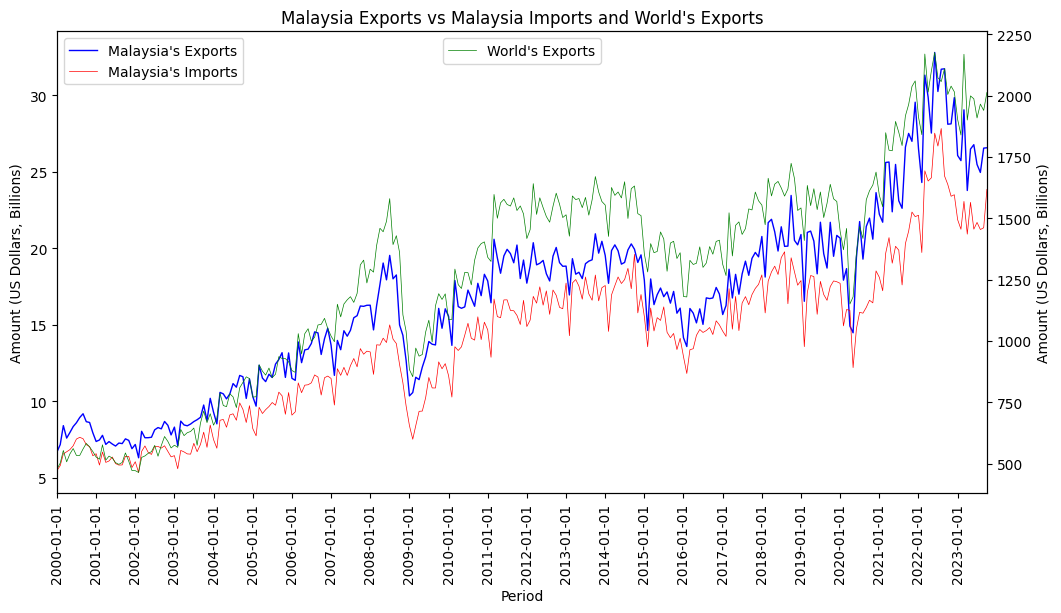

In [39]:
# Sample data for multiple lines
x = eda_df['date']
y1 = eda_df['my_total_export']
y2 = eda_df['my_total_import']
y3 = eda_df['world_export']

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the first dataset on the first axis
ax1.plot(x, y1, color='b', label="Malaysia's Exports", linewidth = 1)
ax1.plot(x, y2, color='r', label="Malaysia's Imports", linewidth=0.5)

ax1.set_xlabel('Period')
ax1.set_ylabel('Amount (US Dollars, Billions)', color='black')
ax1.tick_params('y', colors='black')

# Create the second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second dataset on the second axis
ax2.plot(x, y3, color='g', label="World's Exports",linewidth=0.5)

ax2.set_ylabel('Amount (US Dollars, Billions)', color='black')
ax2.tick_params('y', colors='black')

# Set the x-axis limits
ax1.set_xlim(eda_df['date'].min(), eda_df['date'].max())

#Show only every 24th tick and label
ax1.set_xticks(x[::12])
ax1.set_xticklabels(x[::12], rotation=90)  # Adjust rotation as needed


# Add a legend
ax1.set_title("Malaysia Exports vs Malaysia Imports and World's Exports")
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')

# Show the plot
plt.show()

### Chart 2: Malaysia's Trade Balance

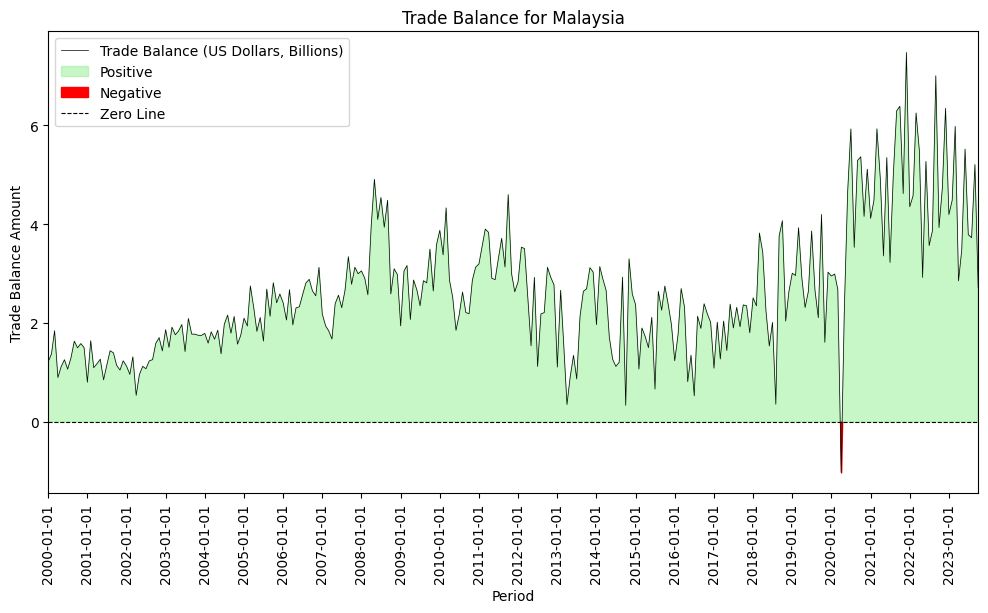

In [40]:
# Sample data
x = eda_df['date']
y = np.array(eda_df['trade_balance'], float)

# Create the figure and the axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the line
ax.plot(x, y, color='black', label='Trade Balance (US Dollars, Billions)', linewidth = 0.5)

# Fill the area above the zero line with green
ax.fill_between(x, y, where=(y >= 0), interpolate=True, color='lightgreen', alpha=0.5, label='Positive')

# Fill the area below the zero line with red
ax.fill_between(x, y, where=(y < 0), interpolate=True, color='red', alpha=1, label='Negative')

# Set labels and title
ax.set_xlabel('Period')
ax.set_ylabel('Trade Balance Amount')
ax.set_title('Trade Balance for Malaysia')
ax.axhline(0, color='black', linewidth=0.8, linestyle='--', label='Zero Line')  # Add a horizontal line at y=0
ax.legend()

# Set the x-axis limits
ax.set_xlim(eda_df['date'].min(), eda_df['date'].max())

#Show only every 24th tick and label
ax.set_xticks(x[::12])
ax.set_xticklabels(x[::12], rotation=90)  # Adjust rotation as needed

# Plot the legend
ax.legend()

# Show the plot
plt.show()

### Chart 3: Malaysia’s Exports vs USDMYR Exchange Rate

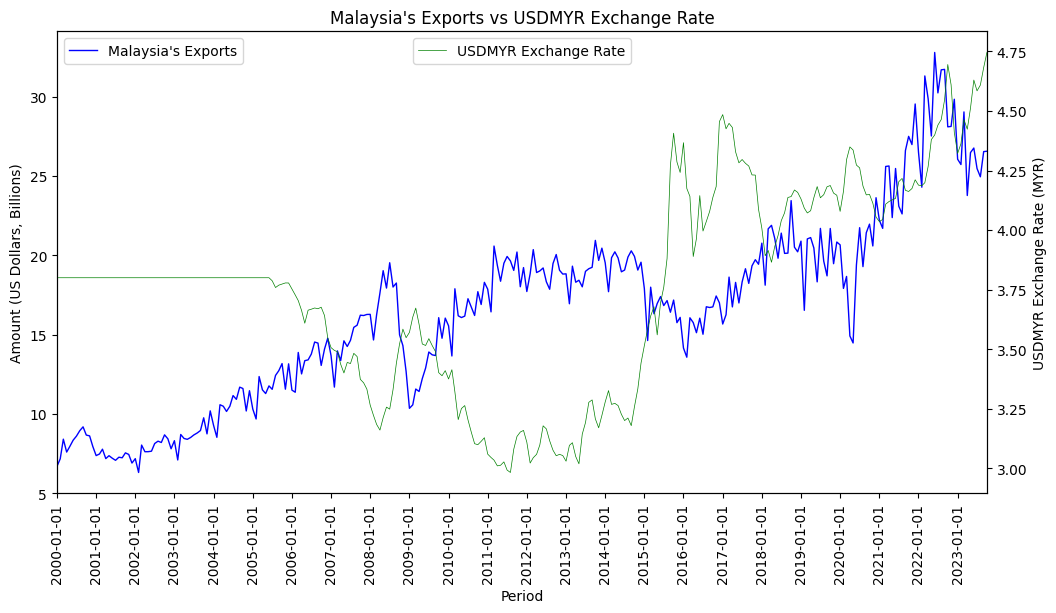

In [41]:
# Sample data for multiple lines
x = eda_df['date']
y1 = eda_df['my_total_export']
y3 = eda_df['er']

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the first dataset on the first axis
ax1.plot(x, y1, color='b', label="Malaysia's Exports", linewidth = 1)
ax1.set_xlabel('Period')
ax1.set_ylabel('Amount (US Dollars, Billions)', color='black')
ax1.tick_params('y', colors='black')

# Create the second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second dataset on the second axis
ax2.plot(x, y3, color='g', label='USDMYR Exchange Rate',linewidth=0.5)
ax2.set_ylabel('USDMYR Exchange Rate (MYR)', color='black')
ax2.tick_params('y', colors='black')

# Set the x-axis limits
ax1.set_xlim(eda_df['date'].min(), eda_df['date'].max())

#Show only every 24th tick and label
ax1.set_xticks(x[::12])
ax1.set_xticklabels(x[::12], rotation=90)  # Adjust rotation as needed
ax1.set_title("Malaysia's Exports vs USDMYR Exchange Rate")

# Add a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')

# Show the plot
plt.show()

### Chart 4: Malaysia’s Total Export Value vs Real Broad Effective Exchange Rate for Malaysia

In [42]:
# Sample data for multiple lines
x = eda_df['date']
y1 = eda_df['my_total_export']
y3 = eda_df['rbeer']

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the first dataset on the first axis
ax1.plot(x, y1, color='b', label= "Malaysia's Exports", linewidth = 1)
ax1.set_xlabel('Period')
ax1.set_ylabel('Amount (US Dollars, Billions)', color='black')
ax1.tick_params('y', colors='black')

# Create the second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second dataset on the second axis
ax2.plot(x, y3, color='g', label='Real Broad Effective Exchange Rate',linewidth=0.5)
ax2.set_ylabel('Index 2020 = 100', color='black')
ax2.tick_params('y', colors='black')

# Set the x-axis limits
ax1.set_xlim(eda_df['date'].min(), eda_df['date'].max())

#Show only every 24th tick and label
ax1.set_xticks(x[::12])
ax1.set_xticklabels(x[::12], rotation=90)  # Adjust rotation as needed
ax1.set_title("Malaysia's Exports vs Real Broad Effective Exchange Rate for Malaysia")

# Add a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')

# Show the plot
plt.show()

### Chart 5: Data correlation between attributes.

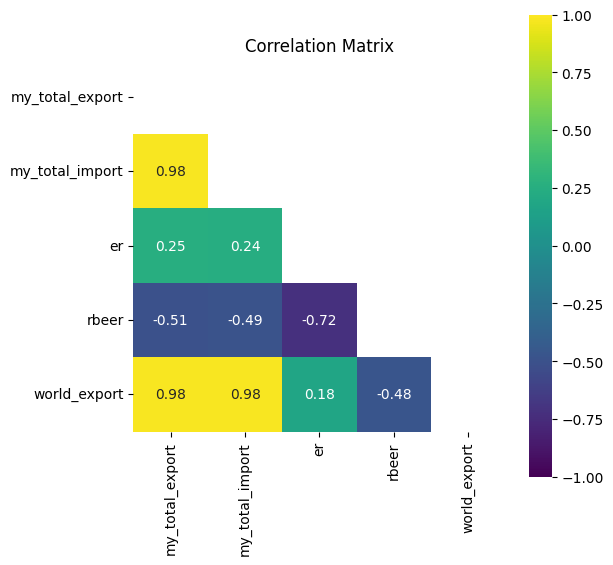

In [43]:
df_corr = eda_df.copy()

# Create a copy of the DataFrame with the target variable dropped
df_corr = df_corr.drop(['trade_balance', 'date'] , axis=1)

# Create a correlation matrix
corr_matrix = df_corr.corr()

# Create a mask to hide the upper triangular portion of the heatmap
mask = np.zeros_like(corr_matrix, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(6,6))

# Create a heatmap of the correlation matrix using seaborn
sns.heatmap(corr_matrix, cmap='viridis', annot=True, vmin=-1, vmax=1, mask=mask, fmt=".2f", square=True, ax=ax)

# Set the title of the plot
ax.set_title('Correlation Matrix')

# Show the plot
plt.show()

## Statistical Modelling Part

### Functions for evaluation of model's performance

In [44]:
# To evaluate the model's performance
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    r2 = r2_score(actual, forecast) #R2
    return rmse, r2

### Non-Stationary Data

In [45]:
# Copy a dataset for modelling purpose
df_model_actual = eda_df.copy()
df_model_actual = df_model_actual.drop(['trade_balance'], axis=1)
df_model_actual['date'] = pd.to_datetime(df_model_actual['date'], infer_datetime_format=True)
df_model_actual = df_model_actual.set_index(['date'])
df_model_actual.head()

my_total_export  my_total_import   er  rbeer  world_export
date                                                                  
2000-01-01         6.692462         5.479822  3.8  95.15    478.638095
2000-02-01         7.179783         5.807194  3.8  96.44    503.130262
2000-03-01         8.418065         6.574967  3.8  96.06    554.571560
2000-04-01         7.605977         6.710651  3.8  96.09    508.309506
2000-05-01         7.965656         6.850567  3.8  97.98    540.215627

### Stationary Data

In [46]:
# Function to check whether the data is stationary or non-stationary
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    ax.plot(series, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

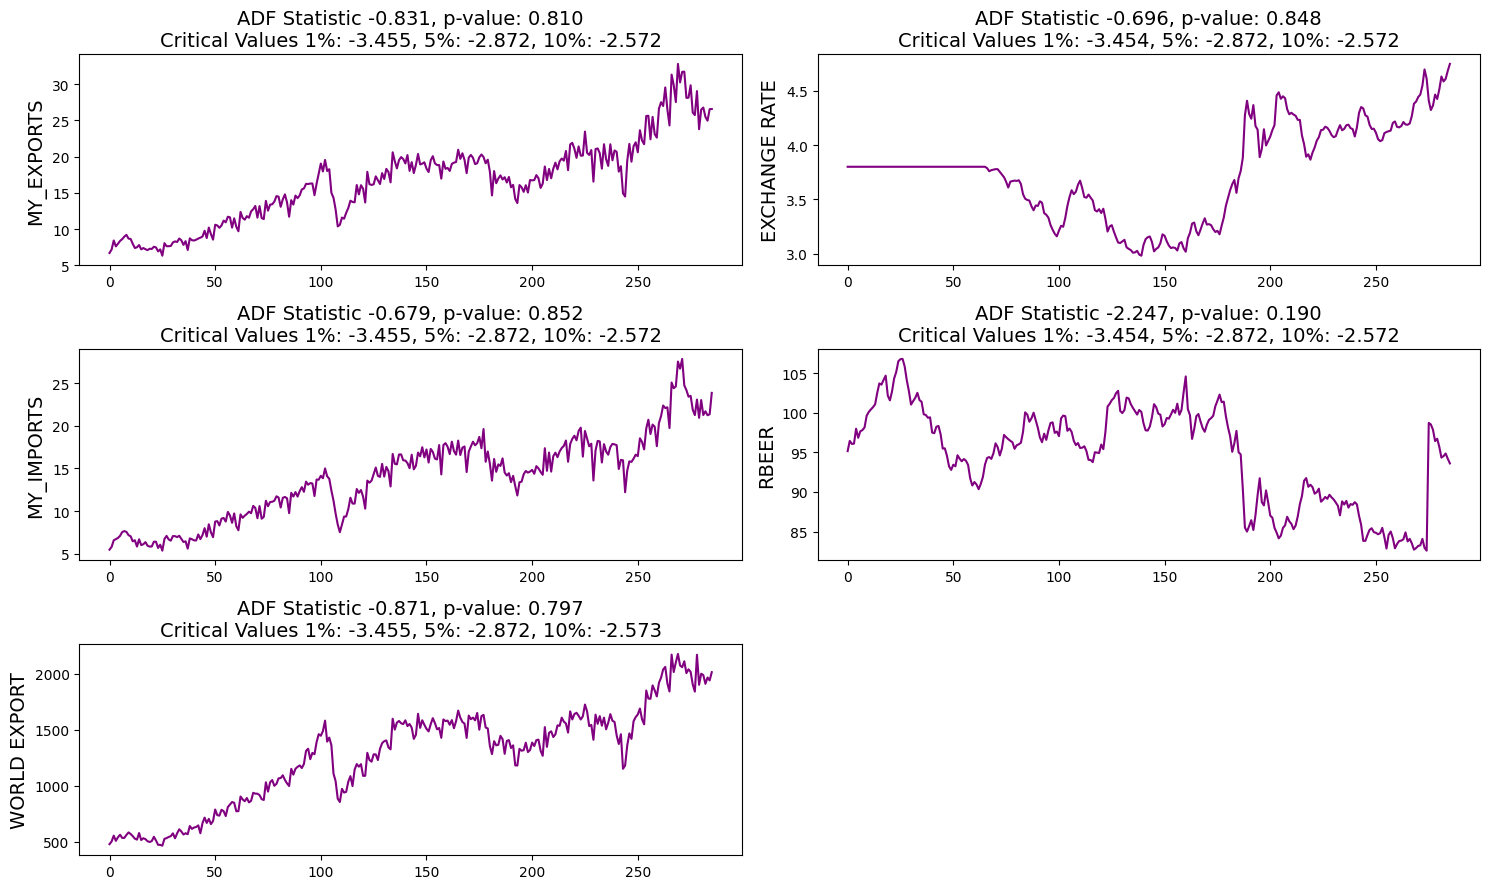

In [47]:
# Check on the Initial Data
df_actual_new = df_model_actual.copy()

f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
visualize_adfuller_results(df_actual_new['my_total_export'].values, 'MY_EXPORTS', ax[0, 0])
visualize_adfuller_results(df_actual_new['my_total_import'].values, 'MY_IMPORTS', ax[1, 0])
visualize_adfuller_results(df_actual_new['er'].values, 'EXCHANGE RATE', ax[0, 1])
visualize_adfuller_results(df_actual_new['rbeer'].values, 'RBEER', ax[1, 1])
visualize_adfuller_results(df_actual_new['world_export'].values, 'WORLD EXPORT', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

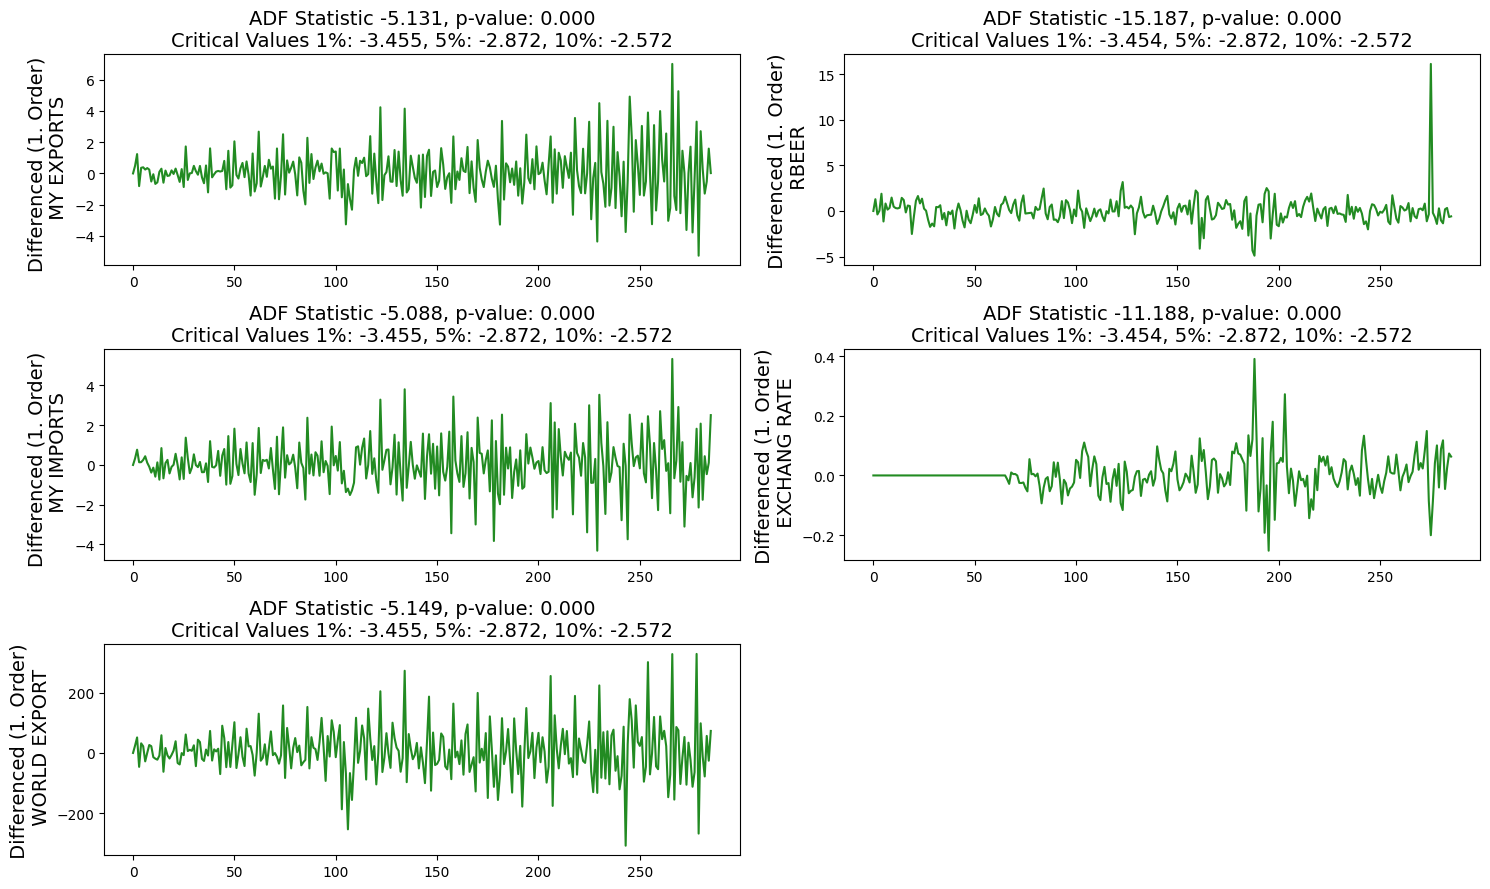

In [48]:
# Perform first order differencing to convert non-stationary data to stationary data
ts_diff = np.diff(df_actual_new['my_total_export'])
df_actual_new['my_total_export'] = np.append([0], ts_diff)

ts_diff = np.diff(df_actual_new['my_total_import'])
df_actual_new['my_total_import'] = np.append([0], ts_diff)

ts_diff = np.diff(df_actual_new['er'])
df_actual_new['er'] = np.append([0], ts_diff)

ts_diff = np.diff(df_actual_new['rbeer'])
df_actual_new['rbeer'] = np.append([0], ts_diff)

ts_diff = np.diff(df_actual_new['world_export'])
df_actual_new['world_export'] = np.append([0], ts_diff)

# Reconduct the ADF test to check for the stationarity of data
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
visualize_adfuller_results(df_actual_new['my_total_export'].values, 'Differenced (1. Order) \n MY EXPORTS', ax[0, 0])
visualize_adfuller_results(df_actual_new['my_total_import'].values, 'Differenced (1. Order) \n MY IMPORTS', ax[1, 0])
visualize_adfuller_results(df_actual_new['er'].values, ' Differenced (1. Order) \n EXCHANG RATE', ax[1, 1])
visualize_adfuller_results(df_actual_new['rbeer'].values, ' Differenced (1. Order) \n RBEER', ax[0, 1])
visualize_adfuller_results(df_actual_new['world_export'].values, ' Differenced (1. Order) \n WORLD EXPORT', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

### Data Splitting Ratio

In [49]:
# Function to split the data into train dataset and test dataset
def data_split(split_ratio, data):
    train_data_list = []
    test_data_list = []
    for value in split_ratio:
        train_size = int(value * len(data))
        test_size = len(data) - train_size
        train_data = df_model_actual.iloc[:train_size]
        test_data = df_model_actual.iloc[train_size:]
        train_data_list.append(train_data)
        test_data_list.append(test_data)
    return train_data_list, test_data_list

# Function to plot the chart to showcase the train dataset and test dataset for validation purposes.\
def plot_data_split(split_ratio, data, attribute, nrow, ncol, figsize_x, figsize_y):
    train_data_list, test_data_list = data_split(split_ratio, data)
    fig, axs = plt.subplots(nrow, ncol, figsize = (figsize_x,figsize_y))
    
    for count in range(len(train_data_list)):
        train_data = pd.DataFrame(train_data_list[count][attribute])
        train_data['Legend'] = 'Train'
        test_data = pd.DataFrame(test_data_list[count][attribute])
        test_data['Legend'] = 'Test'
        df =pd.concat([train_data, test_data])
    
        sns.lineplot(ax = axs[count], data = df, x ='date', y='my_total_export', hue ='Legend', palette=['green','red'])
        axs[count].set_title(f"Data Split {int(split_ratio[count]*100)}:{round((int(1)-split_ratio[count])*100)}")
        axs[count].set(xlabel = 'Period', ylabel = "MY_Exports (USD Billions)")
        
    plt.tight_layout()
    plt.show()

In [50]:
split_ratio = [0.7, 0.8, 0.9]
data = df_model_actual

train_data_list, test_data_list = data_split(split_ratio, data)

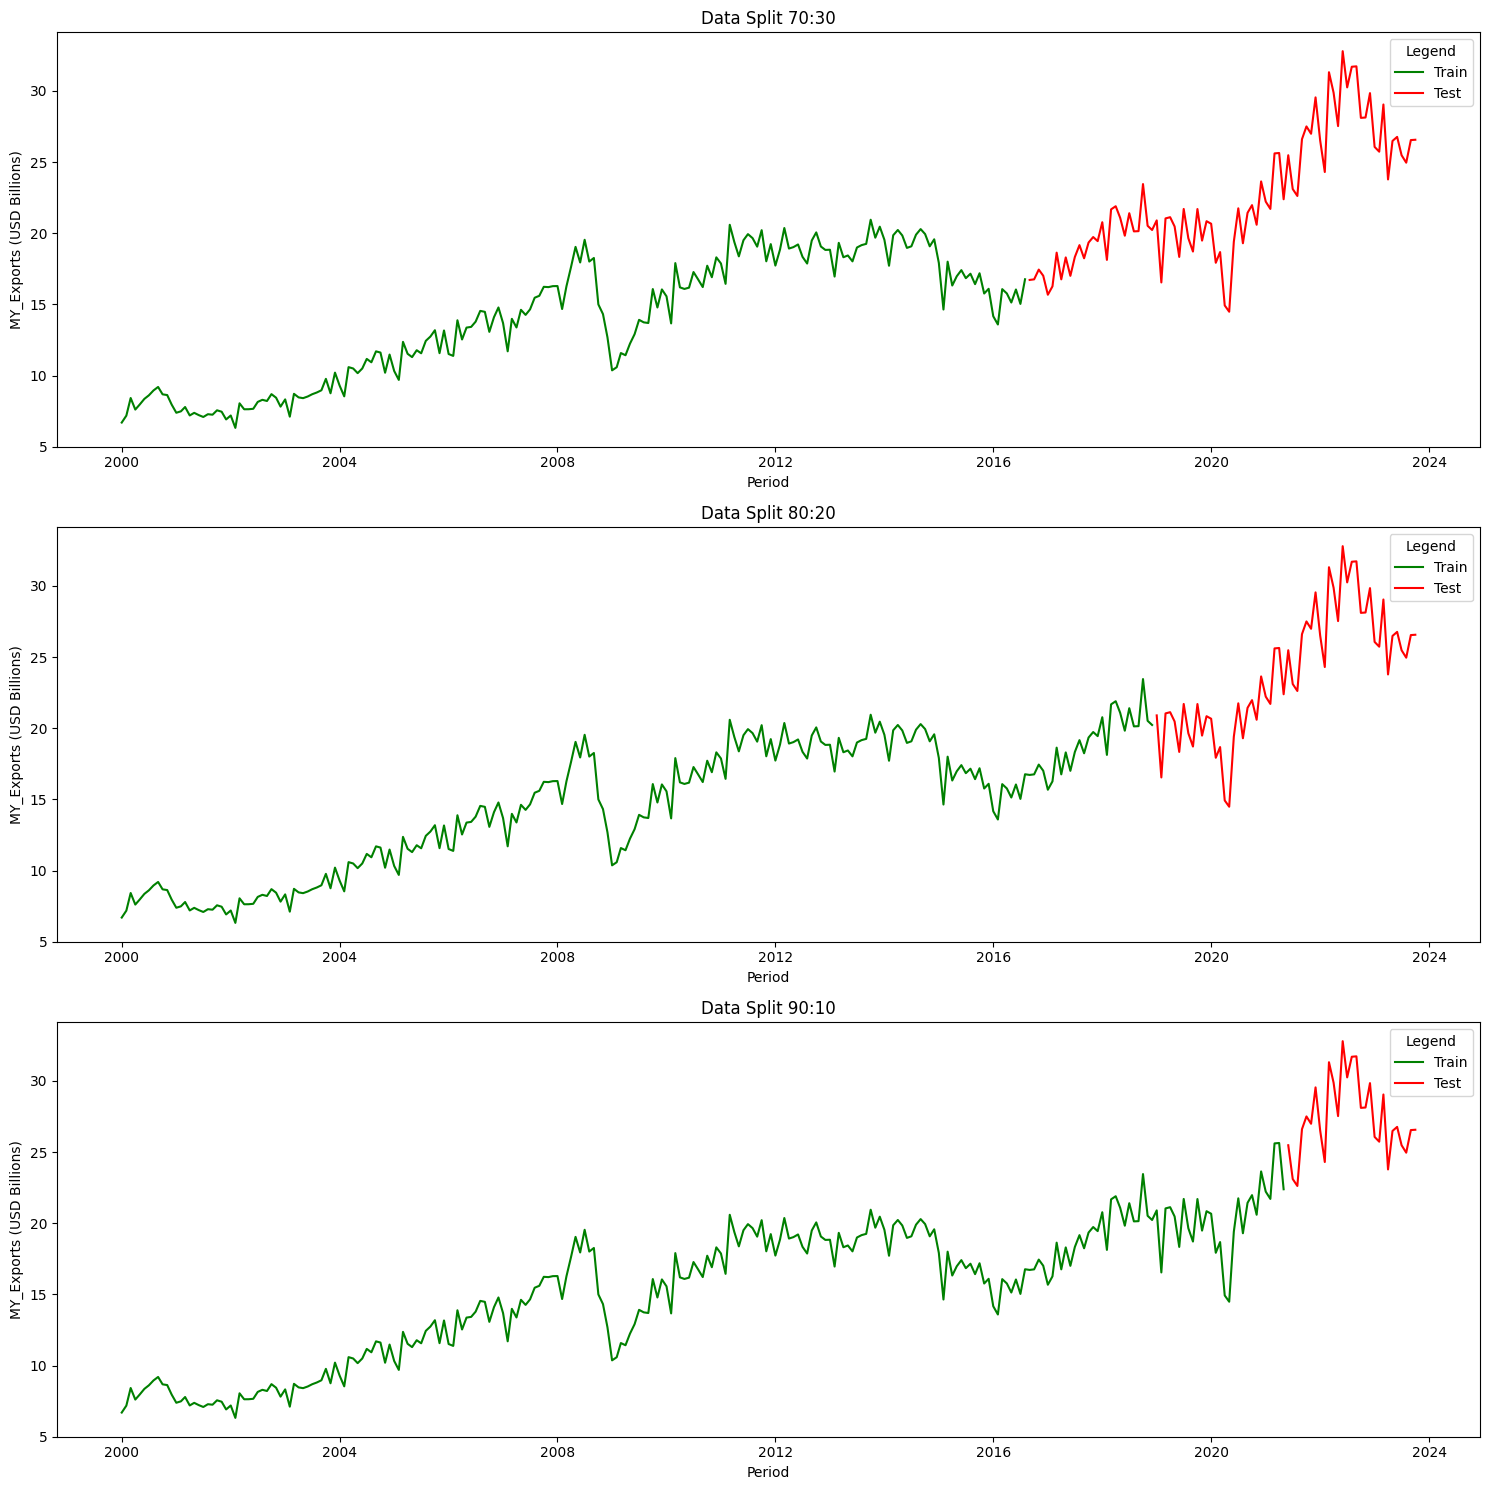

In [51]:
plot_data_split(split_ratio, data, attribute=['my_total_export'], nrow=3, ncol=1, figsize_x=15, figsize_y=15)

### ARIMA & SARIMA

In [52]:
def arima_modeling(original_data, train_data_list, test_data_list, seasonal, attribute):
    data_fc = []
    data_lower = []
    data_upper = []
    data_aic = []
    data_fitted = []
    data_index_of_fc = []
    seasonal_list = []
    
    for i in range(len(train_data_list)):
        train_data = train_data_list[i][attribute]
        test_data = test_data_list[i][attribute]
        for i in range(len(seasonal)):
            model = pm.auto_arima(train_data,         # time se
                                  m=12,               # frequency of series                      
                                  seasonal=seasonal[i],     # TRUE if seasonal series
                                  stationary=False,
                                  d=None,             # let model determine 'd'
                                  test='adf',         # use adftest to find optimal 'd'
                                  start_p=0, start_q=0, # minimum p and q
                                  max_p=12, max_q=12, # maximum p and q
                                  D=None,             # let model determine 'D'
                                  max_order=None,
                                  trace=False,
                                  error_action='ignore',  
                                  suppress_warnings=True, 
                                  stepwise=True)
            print(model.summary)
            fc, confint = model.predict(n_periods=len(test_data), return_conf_int=True)
            index_of_fc = pd.date_range(pd.to_datetime(train_data.index[-1])  + relativedelta(months = +1), periods = len(test_data), freq = 'MS')
            
            seasonal_list.append(seasonal[i])
            data_fc.append(fc)
            data_lower.append(confint[:,0])
            data_upper.append(confint[:,1])
            data_aic.append(model.aic())
            data_fitted.append(model.fittedvalues())
            data_index_of_fc.append(index_of_fc)
            actual = test_data['my_total_export']
            forecast = fc
            rmse = np.mean((forecast - actual)**2)**.5  # RMSE
            r2 = r2_score(actual, forecast) #R2
            print(f'RMSE: {rmse}, R2: {r2}')

    df_act_fc_list = []
    df_lower_list = []
    df_upper_list = []
    df_fitted_list = []
    
    for i in range(len(data_fc)):
        df_fc = pd.DataFrame(index = data_index_of_fc[i])
        df_lower = pd.DataFrame(index = data_index_of_fc[i])
        df_upper = pd.DataFrame(index = data_index_of_fc[i])
        df_aic = pd.DataFrame()
        df_fitted = pd.DataFrame(index = original_data.index)

        df_fc['my_total_export'] = data_fc[i]
        df_lower['my_total_export'] = data_lower[i]
        df_upper['my_total_export'] = data_upper[i]
        df_aic['my_total_export'] = data_aic[i]
        df_fitted['my_total_export'] = data_fitted[i]
        
        actual_data = original_data['my_total_export'].copy()
        actual_data = pd.DataFrame(actual_data)
        forecast_data = df_fc
        actual_data['desc'] = 'Actual'
        forecast_data['desc'] = 'Forecast'
        df_act_fc = pd.concat([actual_data, forecast_data]).reset_index()
        df_act_fc = df_act_fc.rename(columns={'index': 'date'})
        df_act_fc_list.append(df_act_fc)
        df_lower_list.append(df_lower)
        df_upper_list.append(df_upper)
        df_fitted_list.append(df_fitted)
        
    return df_act_fc_list, df_fitted_list, df_lower_list, df_upper_list, seasonal_list

def arima_result_plot(df_act_fc_list, df_fitted_list, df_lower_list, df_upper_list, split_ratio, seasonal_list):
    
    split_ratio_list = [item for item in split_ratio for _ in range(2)]
    
    years = mdates.YearLocator()    # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')
    
    for i in range(len(df_act_fc_list)):
        df_melt = df_act_fc_list[i].melt(id_vars=['date', 'desc'])
        df_melt_fitted = df_fitted_list[i].reset_index().melt(id_vars=['date'])

        # Filter data for the current category
        df_plot = df_melt[df_melt['variable'] == 'my_total_export']
        df_lower_plot = df_lower_list[i]['my_total_export']
        df_upper_plot = df_upper_list[i]['my_total_export']
        df_plot_fitted = df_melt_fitted[df_melt_fitted['variable'] == 'my_total_export']

        # Create a new figure for each iteration
        fig, ax = plt.subplots(figsize=(15,5), dpi=100)

        # Plot the actual and forecasted data
        sns.lineplot(ax=ax, data=df_plot, x='date', y='value', hue='desc')
        # Plot the fitted data with dashed lines
        sns.lineplot(ax=ax, data=df_plot_fitted, x='date', y='value', dashes=True, alpha=0.5)
        # Set the x-label, y-label, and fill between the lower and upper bounds of the forecast
        ax.set_xlabel('my_total_export', size=12)
        ax.set_ylabel('USD Billions', size=12)
        if seasonal_list[i] == False:
            ax.set_title(f"ARIMA Plot with {int(split_ratio_list[i]*100)}:{round((int(1)-split_ratio_list[i])*100)} Split Ratio")
            ax.fill_between(df_lower_plot.index, df_lower_plot, df_upper_plot, color='k', alpha=.15)
            # Set the legend and y-limits
            ax.legend(loc='upper left')
            ax.set_ylim([df_plot['value'].min(), df_plot['value'].max()])
            plt.savefig(f"images/ARIMA{round((1-split_ratio_list[i])*100)}_{round(split_ratio_list[i]*100)}.jpeg")

            # Set the x-axis tickers and format
            ax.xaxis.set_major_locator(years)
            ax.xaxis.set_major_formatter(years_fmt)
            ax.xaxis.set_minor_locator(months)

            plt.show()
        else:
            ax.set_title(f"SARIMA Plot with {int(split_ratio_list[i]*100)}:{round((int(1)-split_ratio_list[i])*100)} Split Ratio")
            ax.fill_between(df_lower_plot.index, df_lower_plot, df_upper_plot, color='k', alpha=.15)
            # Set the legend and y-limits
            ax.legend(loc='upper left')
            ax.set_ylim([df_plot['value'].min(), df_plot['value'].max()])
            plt.savefig(f"images/SARIMA{round((1-split_ratio_list[i])*100)}_{round(split_ratio_list[i]*100)}.jpeg")

            # Set the x-axis tickers and format
            ax.xaxis.set_major_locator(years)
            ax.xaxis.set_major_formatter(years_fmt)
            ax.xaxis.set_minor_locator(months)

            plt.show()

C:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:62 UserWarning: m (12) set for non-seasonal fit. Setting to 0

<bound method ARIMA.summary of ARIMA(order=(0, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>
RMSE: 7.553128848916189, R2: -1.9973540986445197
<bound method ARIMA.summary of ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)>
RMSE: 7.075989100250238, R2: -1.6306227763181438


C:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:62 UserWarning: m (12) set for non-seasonal fit. Setting to 0

<bound method ARIMA.summary of ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>
RMSE: 5.445074394771595, R2: -0.5808928149117576
<bound method ARIMA.summary of ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)>
RMSE: 4.380436833845672, R2: -0.023127208811256406


C:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:62 UserWarning: m (12) set for non-seasonal fit. Setting to 0

<bound method ARIMA.summary of ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)>
RMSE: 3.8993774558546312, R2: -1.2453805726605416
<bound method ARIMA.summary of ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)>
RMSE: 3.6415755080534375, R2: -0.958294691831987


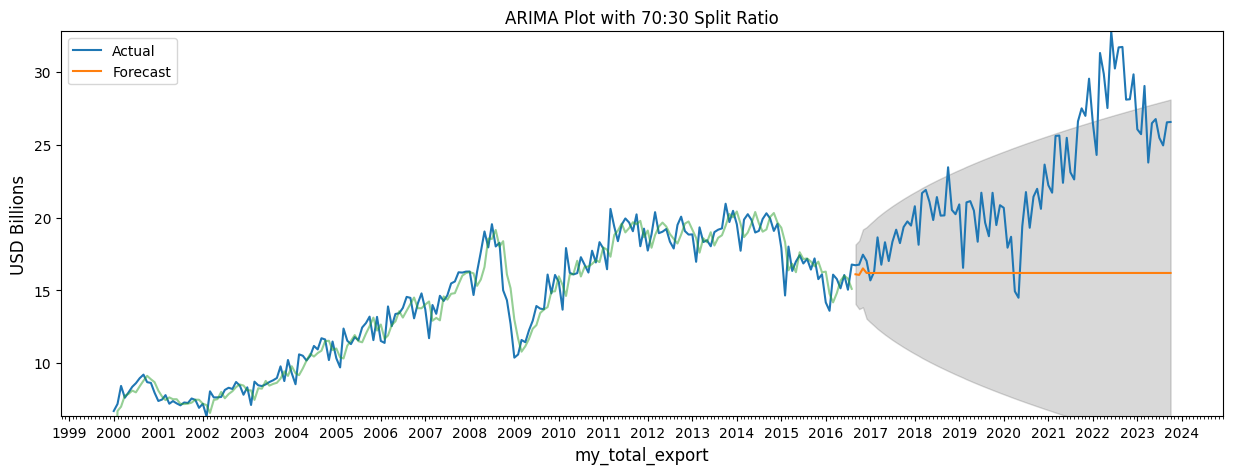

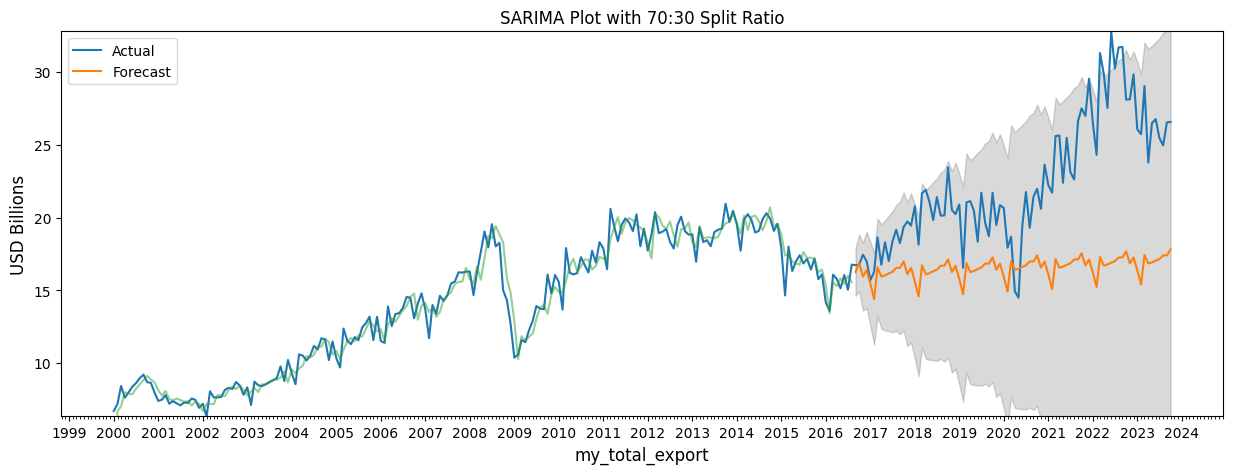

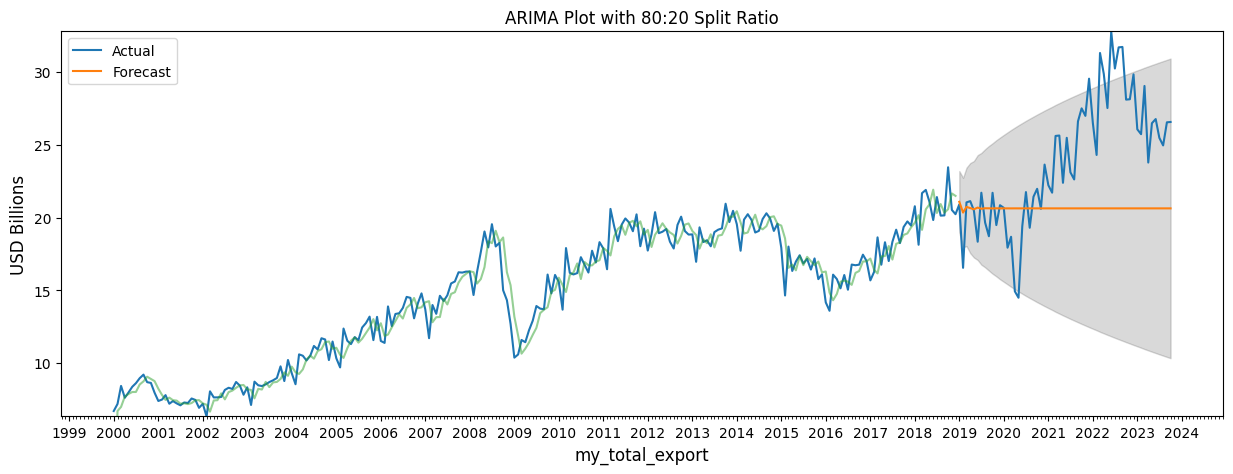

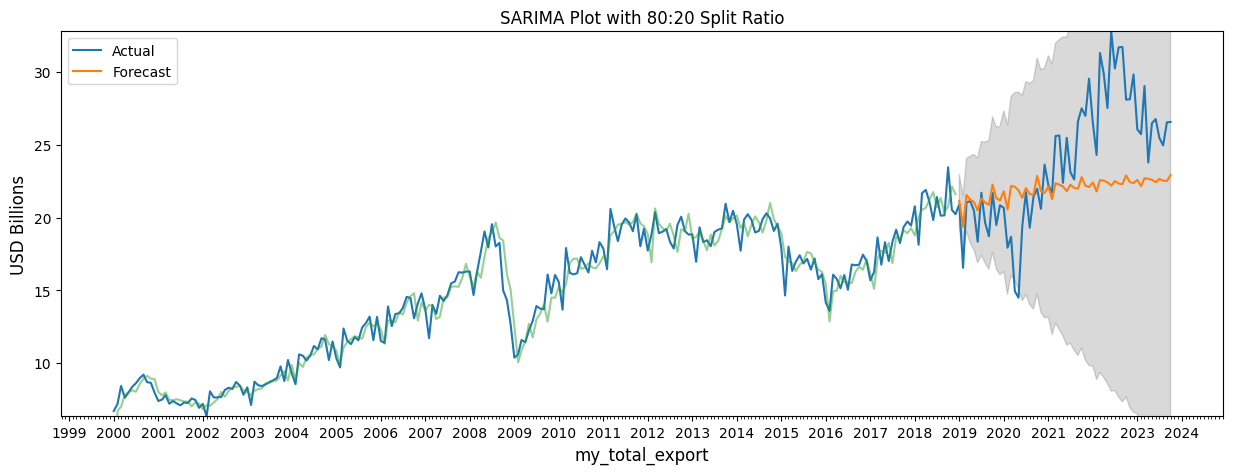

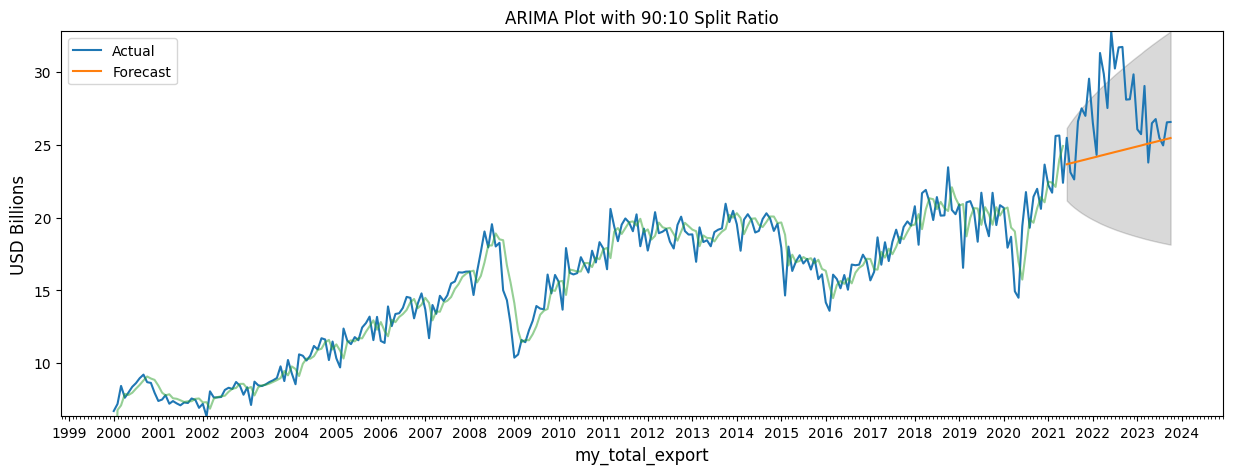

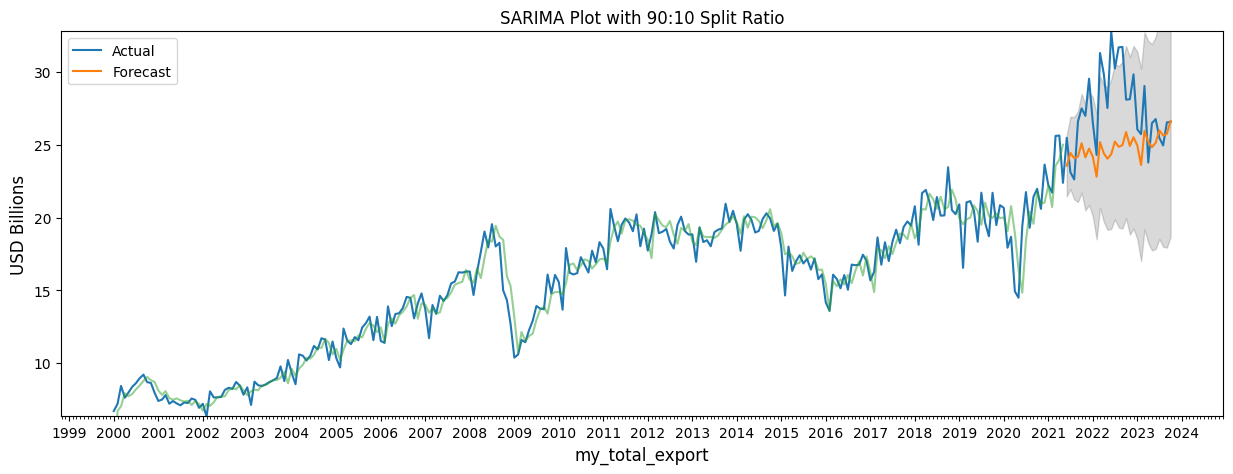

In [53]:
df_act_fc_list, df_fitted_list, df_lower_list, df_upper_list, seasonal_list = arima_modeling(original_data=df_model_actual,
                                                                                train_data_list=train_data_list,
                                                                                test_data_list=test_data_list,
                                                                                seasonal=[False, True],
                                                                                attribute=['my_total_export'])

arima_result_plot(df_act_fc_list, 
                  df_fitted_list, 
                  df_lower_list, 
                  df_upper_list,
                  split_ratio,
                  seasonal_list)

## Machine Learning Regression Modelling Part

In [54]:
# Non-Stationary Data
X = df_model_actual.drop(['my_total_export'],1)
Y = df_model_actual['my_total_export']

C:\Users\Albert\AppData\Local\Temp\ipykernel_54568\1492426162.py:2 FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

In [55]:
# Stationary Data
X1 = df_actual_new.drop(['my_total_export'],1)
Y1 = df_actual_new['my_total_export']

C:\Users\Albert\AppData\Local\Temp\ipykernel_54568\3140015088.py:2 FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

### Linear Regression Model

In [56]:
def linear_regression_model(X, Y, test_size_list, stationary):
    X_train_list = []
    X_test_list =[]
    Y_train_list = []
    Y_test_list = []
    
    for i in range(len(test_size_list)):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size_list[i], random_state=2, shuffle=False)
        X_train_list.append(X_train)
        X_test_list.append(X_test)
        Y_train_list.append(Y_train)
        Y_test_list.append(Y_test)
    
    for i in range(len(Y_train_list)):
        regressor = LinearRegression()
        regressor.fit(X_train_list[i],Y_train_list[i])
        test_data_prediction = regressor.predict(X_test_list[i])
        actual = Y_test_list[i]
        forecast = test_data_prediction
        rmse, r2 = forecast_accuracy(forecast,actual)
        print("Model Name: Linear Regression")
        print(f"RMSE: {round(rmse,3)}")
        print(f"R2: {round(r2,3)}")
        
        split_ratio = test_size_list[i]
        
        if stationary is not True:
            # Plotting
            Y_predict = pd.DataFrame(forecast, index = Y_test_list[i].index)
            plt.figure(figsize=(10,5), dpi=100)
            plt.plot(Y_train_list[i], color='green', label='training data')
            plt.plot(Y_test_list[i], color='blue', label='Actual Value')
            plt.plot(Y_predict, color='red', label='Predicted Value')
            plt.suptitle('Total Export Value of Malaysia')
            plt.title(f'Data Split {round((1-split_ratio)*100)}:{round(split_ratio*100)},  Model: Linear Regression,  Data Type: Non-Stationary', fontsize=10)
            plt.xlabel('Year')
            plt.ylabel('Total Export Value (in billions USD)')
            plt.legend()
            plt.savefig(f"images/LR_NonStationary_{round((1-split_ratio)*100)}_{round(split_ratio*100)}.jpeg")
            plt.show()

        else:
            original_Y_train = []
            initial_train_value = Y_train_list[i][0]
            data = Y_train_list[i]
            for j in range(len(data)):
                initial_train_value = initial_train_value + data[j]
                original_Y_train.append(initial_train_value)

            original_forecast_value = []
            initial_forecast_value = original_Y_train[-1]

            for j in range(len(forecast)):
                initial_forecast_value = initial_forecast_value + forecast[j]
                original_forecast_value.append(initial_forecast_value)

            original_Y_test = []
            initial_test_value = original_Y_train[-1]
            data = Y_test_list[i]
            for j in range(len(data)):
                initial_test_value = initial_test_value + data[j]
                original_Y_test.append(initial_test_value)

            Y_predict = pd.DataFrame(original_forecast_value).set_index(Y_test_list[i].index)
            Y_train = pd.DataFrame(original_Y_train).set_index(Y_train_list[i].index)
            Y_test = pd.DataFrame(original_Y_test).set_index(Y_test_list[i].index)

            plt.figure(figsize=(10,5), dpi=100)
            plt.plot(Y_train, color='green', label='training data')
            plt.plot(Y_test, color='blue', label='Actual Value')
            plt.plot(Y_predict, color='red', label='Predicted Value')
            plt.suptitle('Total Export Value of Malaysia')
            plt.title(f'Data Split {round((1-split_ratio)*100)}:{round(split_ratio*100)},  Model: Linear Regression,  Data Type: Stationary', fontsize=10)
            plt.xlabel('Year')
            plt.ylabel('Total Export Value (in billions USD)')
            plt.legend()
            plt.savefig(f"images/LR_Stationary_{round((1-split_ratio)*100)}_{round(split_ratio*100)}.jpeg")
            plt.show()

Model Name: Linear Regression
RMSE: 2.755
R2: -0.121


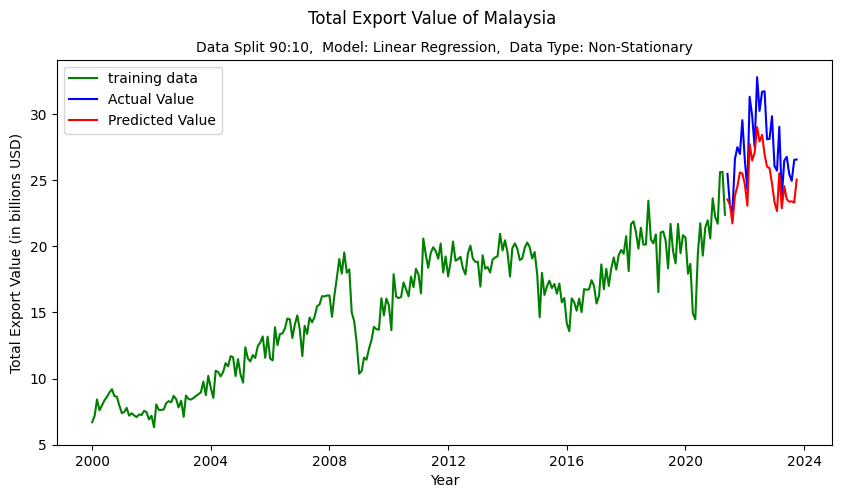

Model Name: Linear Regression
RMSE: 2.74
R2: 0.6


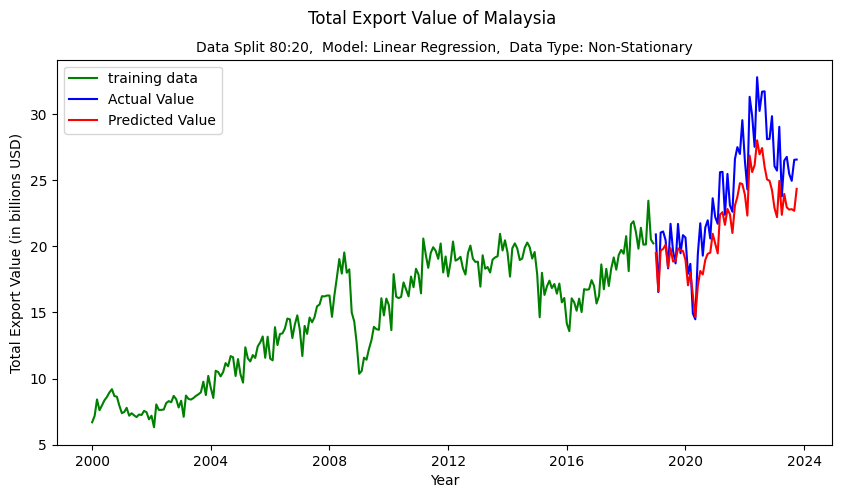

Model Name: Linear Regression
RMSE: 2.932
R2: 0.548


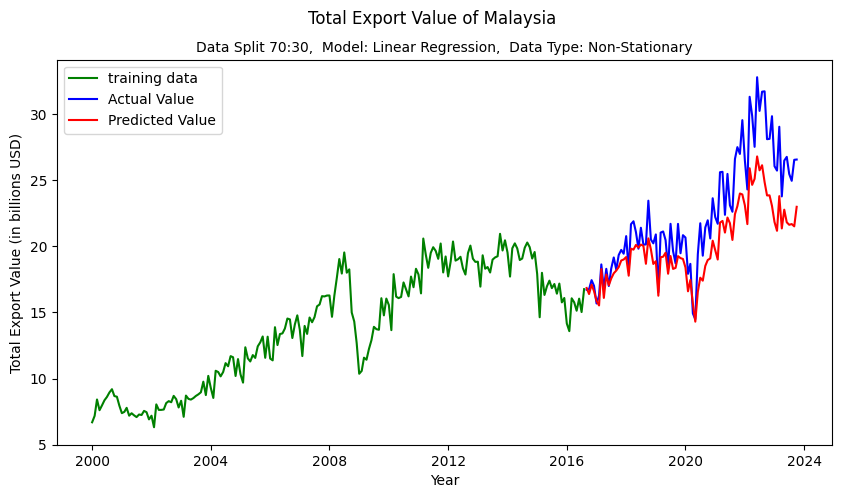

Model Name: Linear Regression
RMSE: 1.788
R2: 0.591


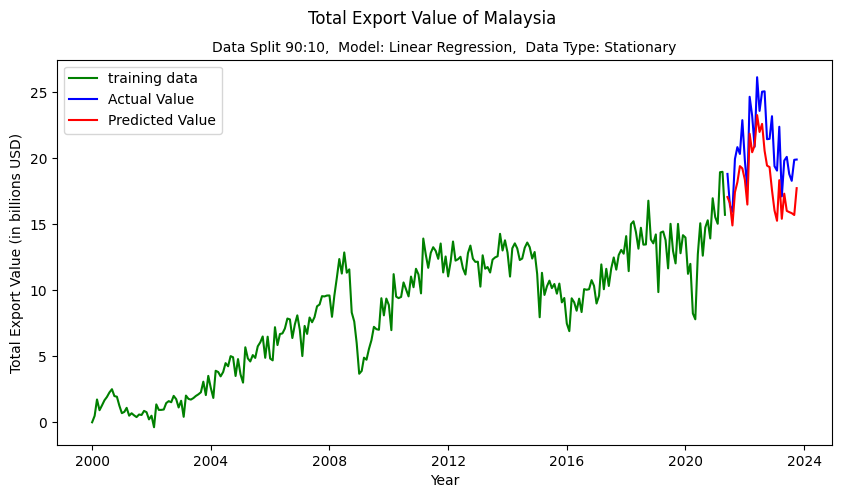

Model Name: Linear Regression
RMSE: 1.63
R2: 0.62


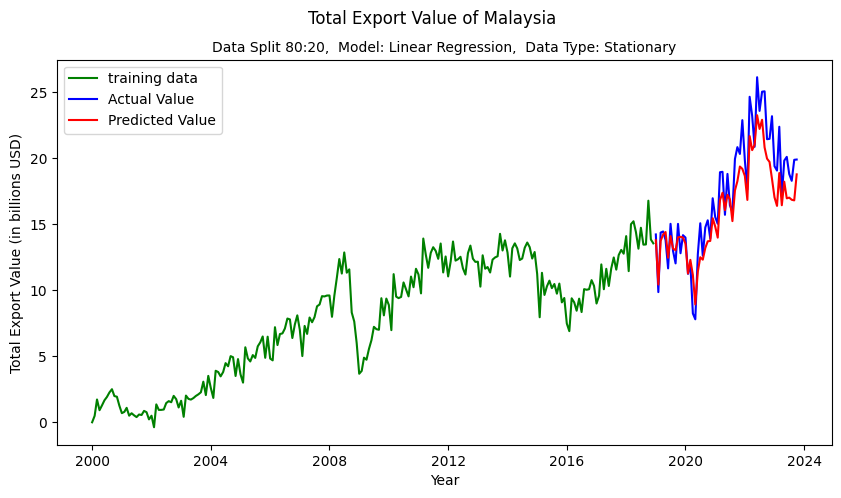

Model Name: Linear Regression
RMSE: 1.434
R2: 0.626


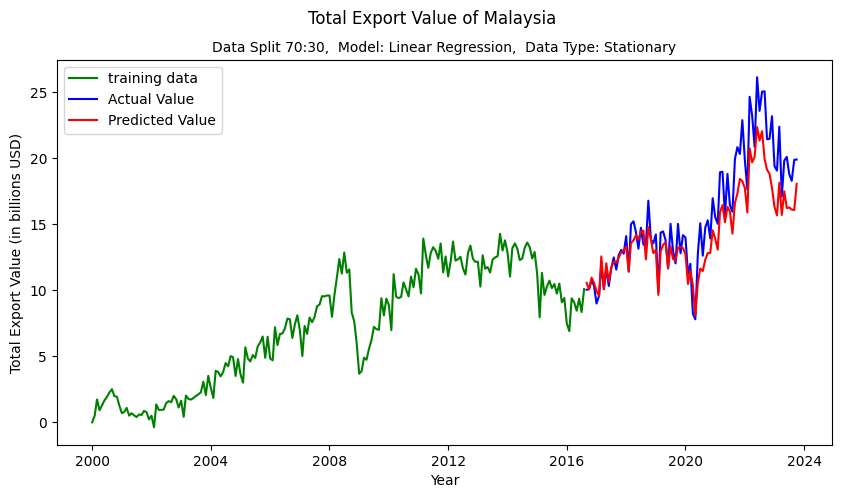

In [57]:
linear_regression_model(X, Y, test_size_list = [0.1, 0.2, 0.3], stationary=False)
linear_regression_model(X1, Y1, test_size_list = [0.1, 0.2, 0.3], stationary=True)

### Support Vector Regressor

In [58]:
def svr_model(X, Y, test_size_list, stationary):
    X_train_list = []
    X_test_list =[]
    Y_train_list = []
    Y_test_list = []
    
    for i in range(len(test_size_list)):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size_list[i], random_state=2, shuffle=False)
        X_train_list.append(X_train)
        X_test_list.append(X_test)
        Y_train_list.append(Y_train)
        Y_test_list.append(Y_test)
    
    for i in range(len(Y_train_list)):
        regressor = SVR()
        regressor.fit(X_train_list[i],Y_train_list[i])
        test_data_prediction = regressor.predict(X_test_list[i])
        actual = Y_test_list[i]
        forecast = test_data_prediction
        rmse, r2 = forecast_accuracy(forecast,actual)
        print("Model Name: SVR")
        print(f"RMSE: {round(rmse,3)}")
        print(f"R2: {round(r2,3)}")
        
        split_ratio = test_size_list[i]
        
        if stationary is not True:
            # Plotting
            Y_predict = pd.DataFrame(forecast, index = Y_test_list[i].index)
            plt.figure(figsize=(10,5), dpi=100)
            plt.plot(Y_train_list[i], color='green', label='training data')
            plt.plot(Y_test_list[i], color='blue', label='Actual Value')
            plt.plot(Y_predict, color='red', label='Predicted Value')
            plt.suptitle('Total Export Value of Malaysia')
            plt.title(f'Data Split {round((1-split_ratio)*100)}:{round(split_ratio*100)},  Model: SVR,  Data Type: Non-Stationary', fontsize=10)
            plt.xlabel('Year')
            plt.ylabel('Total Export Value (in billions USD)')
            plt.legend()
            plt.savefig(f"images/SVR_NonStationary{round((1-split_ratio)*100)}_{round(split_ratio*100)}.jpeg")

            plt.show()

        else:
            original_Y_train = []
            initial_train_value = Y_train_list[i][0]
            data = Y_train_list[i]
            for j in range(len(data)):
                initial_train_value = initial_train_value + data[j]
                original_Y_train.append(initial_train_value)

            original_forecast_value = []
            initial_forecast_value = original_Y_train[-1]

            for j in range(len(forecast)):
                initial_forecast_value = initial_forecast_value + forecast[j]
                original_forecast_value.append(initial_forecast_value)

            original_Y_test = []
            initial_test_value = original_Y_train[-1]
            data = Y_test_list[i]
            for j in range(len(data)):
                initial_test_value = initial_test_value + data[j]
                original_Y_test.append(initial_test_value)

            Y_predict = pd.DataFrame(original_forecast_value).set_index(Y_test_list[i].index)
            Y_train = pd.DataFrame(original_Y_train).set_index(Y_train_list[i].index)
            Y_test = pd.DataFrame(original_Y_test).set_index(Y_test_list[i].index)

            plt.figure(figsize=(10,5), dpi=100)
            plt.plot(Y_train, color='green', label='training data')
            plt.plot(Y_test, color='blue', label='Actual Value')
            plt.plot(Y_predict, color='red', label='Predicted Value')
            plt.suptitle('Total Export Value of Malaysia')
            plt.title(f'Data Split {round((1-split_ratio)*100)}:{round(split_ratio*100)},  Model: SVR,  Data Type: Stationary', fontsize=10)
            plt.xlabel('Year')
            plt.ylabel('Total Export Value (in billions USD)')
            plt.legend()
            plt.savefig(f"images/SVR_Stationary{round((1-split_ratio)*100)}_{round(split_ratio*100)}.jpeg")
            plt.show()

Model Name: SVR
RMSE: 6.651
R2: -5.532


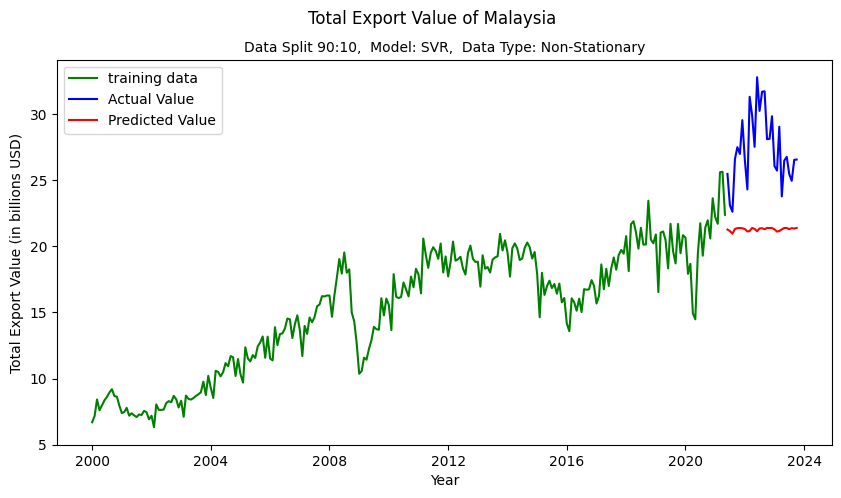

Model Name: SVR
RMSE: 5.377
R2: -0.541


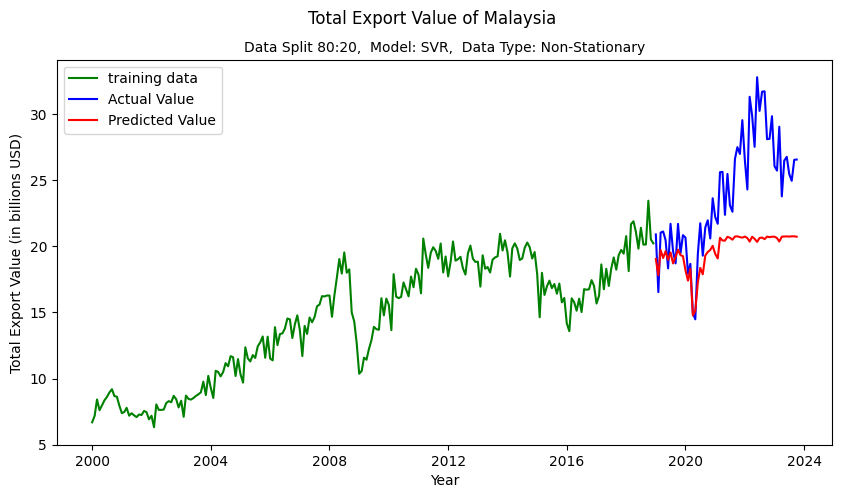

Model Name: SVR
RMSE: 4.959
R2: -0.292


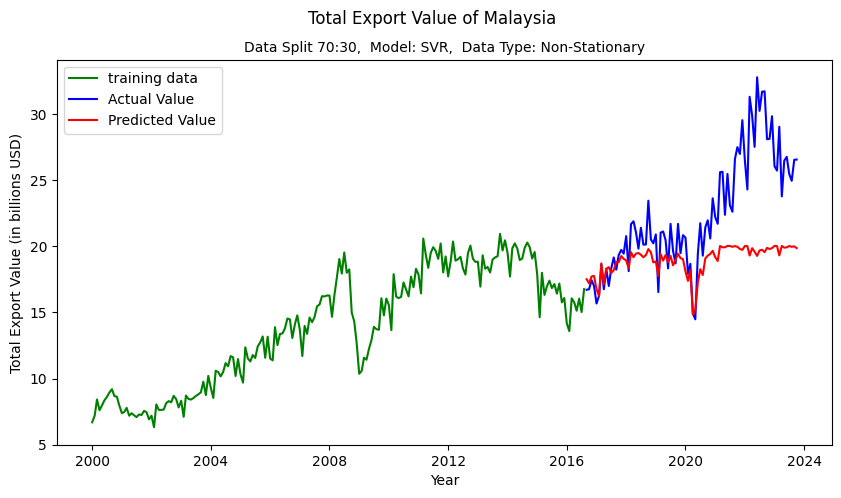

Model Name: SVR
RMSE: 2.138
R2: 0.415


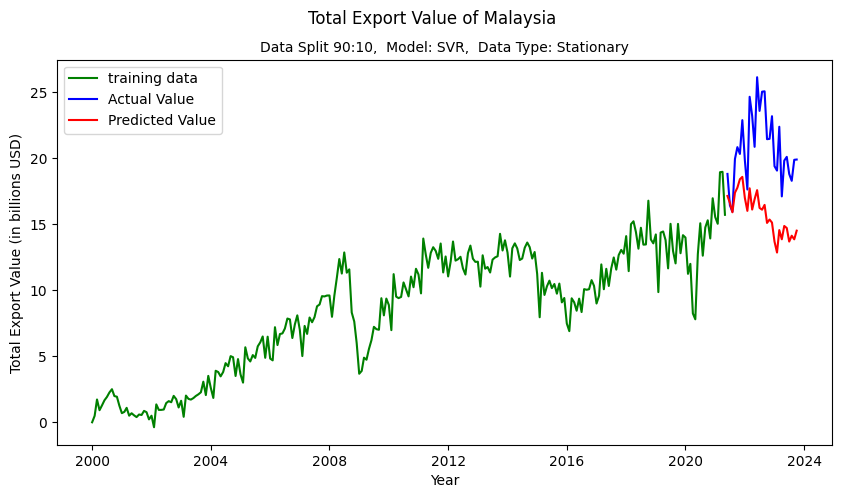

Model Name: SVR
RMSE: 2.041
R2: 0.404


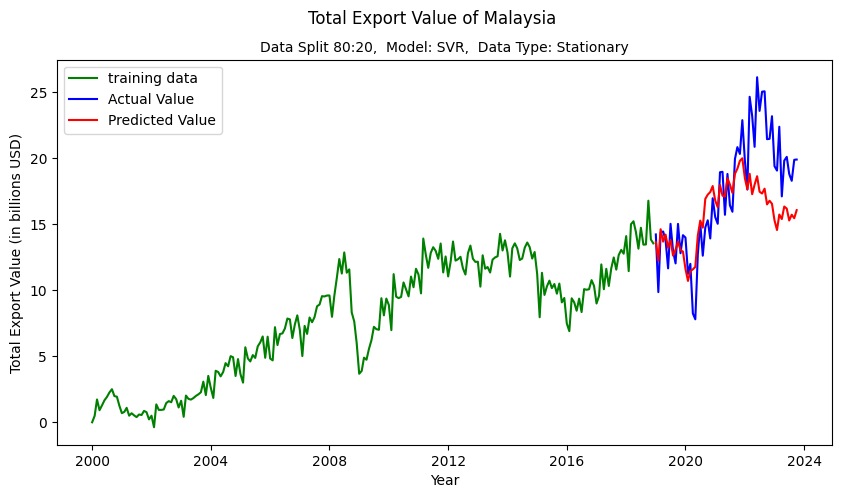

Model Name: SVR
RMSE: 1.836
R2: 0.388


In [59]:
svr_model(X, Y, test_size_list=[0.1, 0.2, 0.3], stationary=False)
svr_model(X1, Y1, test_size_list=[0.1, 0.2, 0.3], stationary=True)

### Gradient Boosting Regressor Model

In [60]:
def gradient_boosting_model(X, Y, test_size_list, estimator, n_estimators, stationary):
    X_train_list = []
    X_test_list =[]
    Y_train_list = []
    Y_test_list = []
    
    for i in range(len(test_size_list)):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size_list[i], random_state=2, shuffle=False)
        X_train_list.append(X_train)
        X_test_list.append(X_test)
        Y_train_list.append(Y_train)
        Y_test_list.append(Y_test)
    
    for i in range(len(Y_train_list)):
        regressor = GradientBoostingRegressor()
        regressor.fit(X_train_list[i],Y_train_list[i])
        test_data_prediction = regressor.predict(X_test_list[i])
        actual = Y_test_list[i]
        forecast = test_data_prediction
        rmse, r2 = forecast_accuracy(forecast,actual)
        print("Model Name: Gradient Boosting")
        print(f"RMSE: {round(rmse,3)}")
        print(f"R2: {round(r2,3)}")
        
        split_ratio = test_size_list[i]
        
        if stationary is not True:
            # Plotting
            Y_predict = pd.DataFrame(forecast, index = Y_test_list[i].index)
            plt.figure(figsize=(10,5), dpi=100)
            plt.plot(Y_train_list[i], color='green', label='training data')
            plt.plot(Y_test_list[i], color='blue', label='Actual Value')
            plt.plot(Y_predict, color='red', label='Predicted Value')
            plt.suptitle('Total Export Value of Malaysia')
            plt.title(f'Data Split {round((1-split_ratio)*100)}:{round(split_ratio*100)},  Model: Gradient Boosting,  Data Type: Non-Stationary', fontsize=10)
            plt.xlabel('Year')
            plt.ylabel('Total Export Value (in billions USD)')
            plt.legend()
            plt.savefig(f"images/GB_NonStationary{round((1-split_ratio)*100)}_{round(split_ratio*100)}.jpeg")
            plt.show()

        else:
            original_Y_train = []
            initial_train_value = Y_train_list[i][0]
            data = Y_train_list[i]
            for j in range(len(data)):
                initial_train_value = initial_train_value + data[j]
                original_Y_train.append(initial_train_value)

            original_forecast_value = []
            initial_forecast_value = original_Y_train[-1]

            for j in range(len(forecast)):
                initial_forecast_value = initial_forecast_value + forecast[j]
                original_forecast_value.append(initial_forecast_value)

            original_Y_test = []
            initial_test_value = original_Y_train[-1]
            data = Y_test_list[i]
            for j in range(len(data)):
                initial_test_value = initial_test_value + data[j]
                original_Y_test.append(initial_test_value)

            Y_predict = pd.DataFrame(original_forecast_value).set_index(Y_test_list[i].index)
            Y_train = pd.DataFrame(original_Y_train).set_index(Y_train_list[i].index)
            Y_test = pd.DataFrame(original_Y_test).set_index(Y_test_list[i].index)

            plt.figure(figsize=(10,5), dpi=100)
            plt.plot(Y_train, color='green', label='training data')
            plt.plot(Y_test, color='blue', label='Actual Value')
            plt.plot(Y_predict, color='red', label='Predicted Value')
            plt.suptitle('Total Export Value of Malaysia')
            plt.title(f'Data Split {round((1-split_ratio)*100)}:{round(split_ratio*100)},  Model: Gradient Boosting,  Data Type: Stationary', fontsize=10)
            plt.xlabel('Year')
            plt.ylabel('Total Export Value (in billions USD)')
            plt.legend()
            plt.savefig(f"images/GB_Stationary{round((1-split_ratio)*100)}_{round(split_ratio*100)}.jpeg")
            plt.show()

Model Name: Gradient Boosting
RMSE: 4.63
R2: -2.165


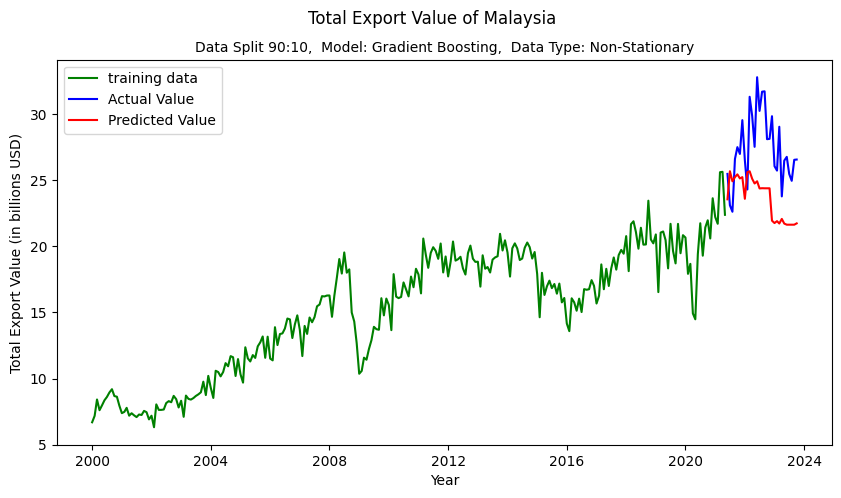

Model Name: Gradient Boosting
RMSE: 4.192
R2: 0.063


Model Name: Gradient Boosting
RMSE: 5.136
R2: -0.386


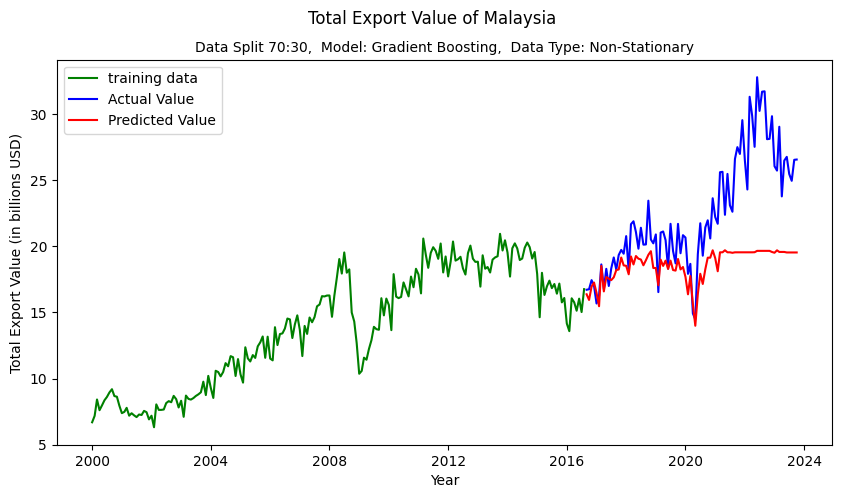

Model Name: Gradient Boosting
RMSE: 2.024
R2: 0.476


Model Name: Gradient Boosting
RMSE: 1.848
R2: 0.511


Model Name: Gradient Boosting
RMSE: 1.598
R2: 0.536


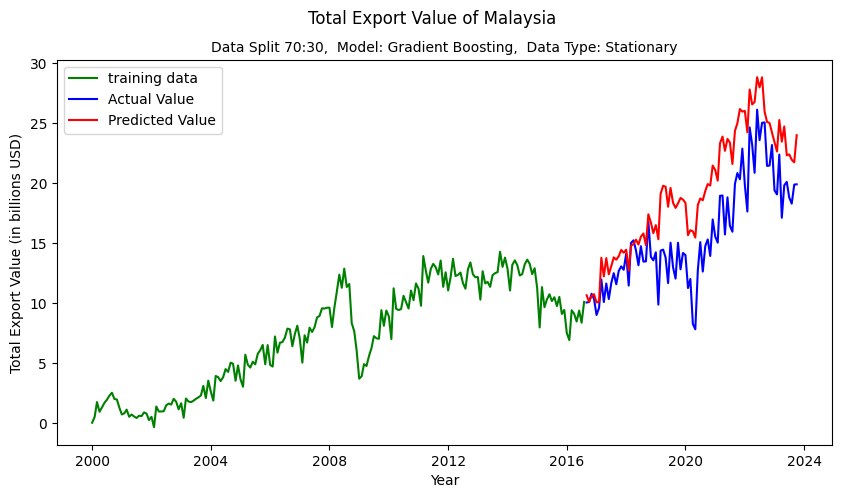

In [61]:
gradient_boosting_model(X, Y,
                        test_size_list=[0.1, 0.2, 0.3],
                        estimator=RandomForestRegressor(), 
                        n_estimators=10,
                        stationary=False)

gradient_boosting_model(X1, Y1,
                        test_size_list=[0.1, 0.2, 0.3],
                        estimator=RandomForestRegressor(), 
                        n_estimators=10,
                        stationary=True)

### Random Forest Model

In [62]:
def random_forest_model(X, Y, test_size_list, n_estimators, stationary):
    X_train_list = []
    X_test_list =[]
    Y_train_list = []
    Y_test_list = []
    
    for i in range(len(test_size_list)):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size_list[i], random_state=2, shuffle=False)
        X_train_list.append(X_train)
        X_test_list.append(X_test)
        Y_train_list.append(Y_train)
        Y_test_list.append(Y_test)
    
    for i in range(len(Y_train_list)):
        regressor = RandomForestRegressor(n_estimators)
        regressor.fit(X_train_list[i],Y_train_list[i])
        test_data_prediction = regressor.predict(X_test_list[i])
        actual = Y_test_list[i]
        forecast = test_data_prediction
        rmse, r2 = forecast_accuracy(forecast,actual)
        print("Model Name: Random Forest")
        print(f"RMSE: {round(rmse,3)}")
        print(f"R2: {round(r2,3)}")
        
        split_ratio = test_size_list[i]
        
        if stationary is not True:
            # Plotting
            Y_predict = pd.DataFrame(forecast, index = Y_test_list[i].index)
            plt.figure(figsize=(10,5), dpi=100)
            plt.plot(Y_train_list[i], color='green', label='training data')
            plt.plot(Y_test_list[i], color='blue', label='Actual Value')
            plt.plot(Y_predict, color='red', label='Predicted Value')
            plt.suptitle('Total Export Value of Malaysia')
            plt.title(f'Data Split {round((1-split_ratio)*100)}:{round(split_ratio*100)},  Model: Random Forest,  Data Type: Non-Stationary', fontsize=10)
            plt.xlabel('Year')
            plt.ylabel('Total Export Value (in billions USD)')
            plt.legend()
            plt.savefig(f"images/RF_NonStationary{round((1-split_ratio)*100)}_{round(split_ratio*100)}.jpeg")

            plt.show()

        else:
            original_Y_train = []
            initial_train_value = Y_train_list[i][0]
            data = Y_train_list[i]
            for j in range(len(data)):
                initial_train_value = initial_train_value + data[j]
                original_Y_train.append(initial_train_value)

            original_forecast_value = []
            initial_forecast_value = original_Y_train[-1]

            for j in range(len(forecast)):
                initial_forecast_value = initial_forecast_value + forecast[j]
                original_forecast_value.append(initial_forecast_value)

            original_Y_test = []
            initial_test_value = original_Y_train[-1]
            data = Y_test_list[i]
            for j in range(len(data)):
                initial_test_value = initial_test_value + data[j]
                original_Y_test.append(initial_test_value)

            Y_predict = pd.DataFrame(original_forecast_value).set_index(Y_test_list[i].index)
            Y_train = pd.DataFrame(original_Y_train).set_index(Y_train_list[i].index)
            Y_test = pd.DataFrame(original_Y_test).set_index(Y_test_list[i].index)

            plt.figure(figsize=(10,5), dpi=100)
            plt.plot(Y_train, color='green', label='training data')
            plt.plot(Y_test, color='blue', label='Actual Value')
            plt.plot(Y_predict, color='red', label='Predicted Value')
            plt.suptitle('Total Export Value of Malaysia')
            plt.title(f'Data Split {round((1-split_ratio)*100)}:{round(split_ratio*100)},  Model: Random Forest,  Data Type: Stationary', fontsize=10)
            plt.xlabel('Year')
            plt.ylabel('Total Export Value (in billions USD)')
            plt.legend()
            plt.savefig(f"images/RF_Stationary{round((1-split_ratio)*100)}_{round(split_ratio*100)}.jpeg")
            plt.show()

Model Name: Random Forest
RMSE: 4.053
R2: -1.426


Model Name: Random Forest
RMSE: 4.222
R2: 0.049


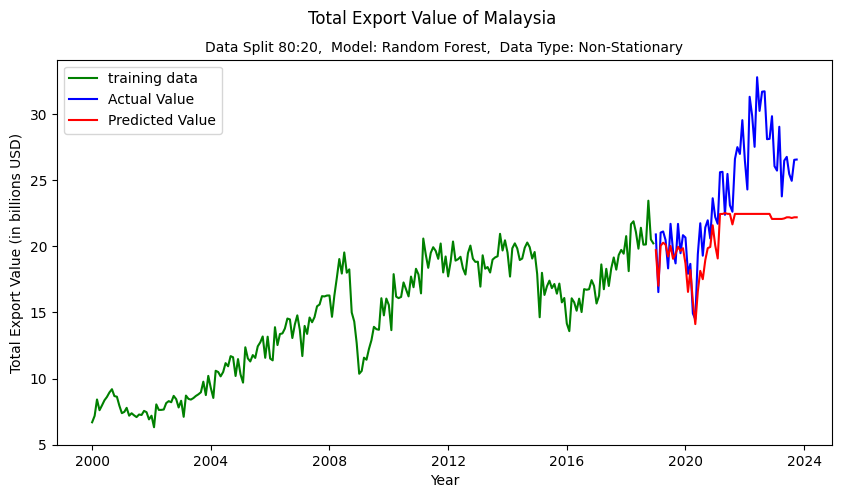

Model Name: Random Forest
RMSE: 4.57
R2: -0.097


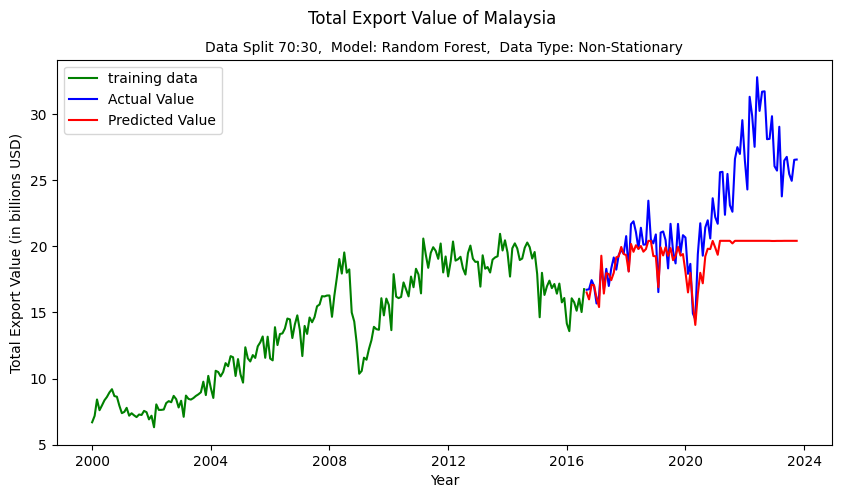

Model Name: Random Forest
RMSE: 1.925
R2: 0.526


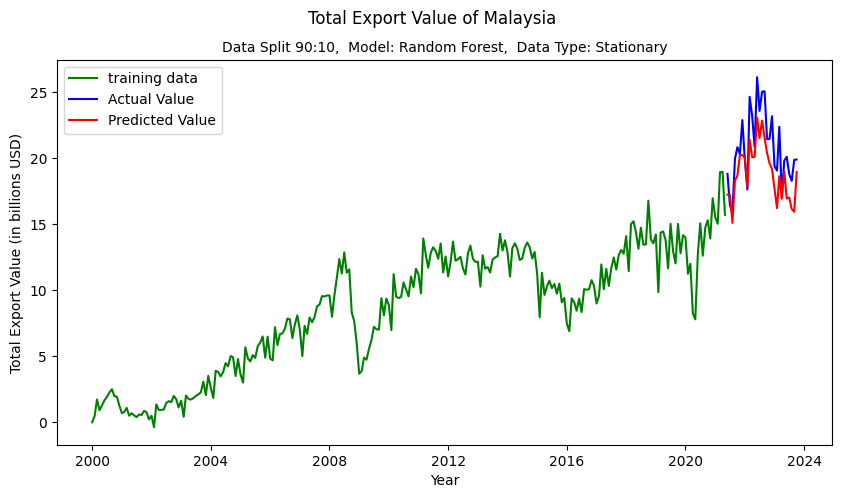

Model Name: Random Forest
RMSE: 1.747
R2: 0.564


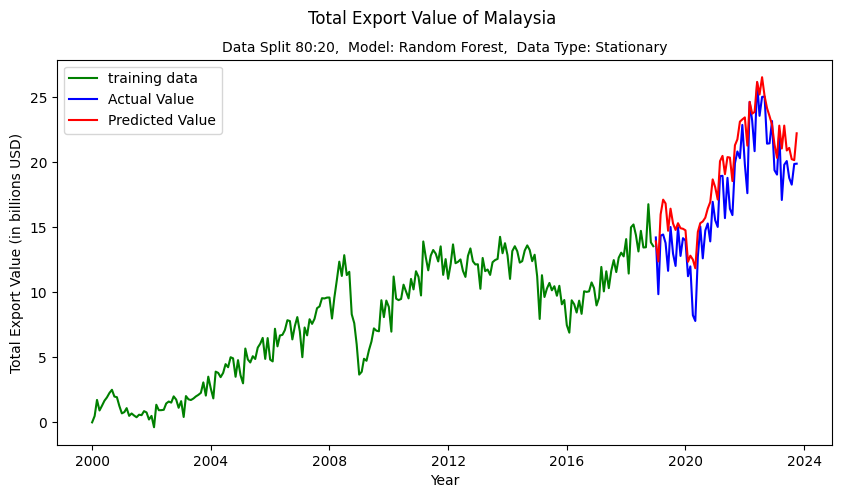

Model Name: Random Forest
RMSE: 1.62
R2: 0.523


In [63]:
random_forest_model(X, Y, test_size_list = [0.1, 0.2, 0.3], n_estimators=100, stationary=False)
random_forest_model(X1, Y1, test_size_list = [0.1, 0.2, 0.3], n_estimators=100, stationary=True)